In [1]:
!pip install ipython-autotime;

In [2]:
!pip install darts;

# Prueba Final

### Integrantes
<small>

 - Francisca Pinto
 - Francisco Silva
 - Paula Rivera
 - Verónica Martínez
 - Benjamín Meneses
</small>

## Preparación del ambiente de Trabajo

In [74]:
#tiempo de ejecución
%load_ext autotime

#dataframe y arrays
import pandas as pd
import numpy as np

#estadística
import scipy.stats as stats

#gráficos
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

#gama matplotlib para facilitar escritura de código
%matplotlib inline

from darts import TimeSeries
from darts.dataprocessing.transformers import MissingValuesFiller
from darts.metrics.metrics import mape, mae
from darts import concatenate
from darts.models.forecasting.arima import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from darts.utils.statistics import extract_trend_and_seasonality, remove_from_series, stationarity_test_adf
from darts.utils.utils import ModelMode
from scipy.stats import normaltest
from darts.utils.model_selection import train_test_split


The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 16 ms (started: 2022-03-12 19:31:12 -03:00)


In [3]:
# Importamos los datos
path_items = 'items.csv'
path_sales = 'salesfact.csv'
path_salesperson = 'vendedores.csv'
path_extra = 'temperatura.csv'

df_items = pd.read_csv(path_items)
df_sales = pd.read_csv(path_sales)
df_salesperson = pd.read_csv(path_salesperson)
df_temperature = pd.read_csv(path_extra)

random_seed = 3748

time: 15 ms (started: 2022-03-12 18:12:57 -03:00)


In [4]:
# Agrupamos según formato
df = df_sales
df['Formato'] = np.where(df['Descripción del artículo'].str.find("200 Gr")+df['Descripción del artículo'].str.find("200Gr")>=0,"200 Gr",
                np.where(df['Descripción del artículo'].str.find("1 Kg")+df['Descripción del artículo'].str.find("1Kg")>=0,"1000 Gr",
                np.where(df['Descripción del artículo'].str.find("5 Kg")+df['Descripción del artículo'].str.find("5Kg")>=0,"5000 Gr","Otro")))
df.Formato.unique()

array(['5000 Gr', '1000 Gr', '200 Gr'], dtype=object)

time: 32 ms (started: 2022-03-12 18:12:57 -03:00)


### Recodificación de columnas

Haremos un análisis de las columnas y pasaremos a refactorizar los nombres

In [5]:
# Vemos las columnas actuales
print('Productos')
print(df_items.columns)
print('Ventas')
print(df_sales.columns)
print('Vendedores')
print(df_salesperson.columns)

Productos
Index(['Familia', 'Peso ( Kg )', 'InventoryUoMName',
       'InventoryValuationMethod_E', 'Es artículo de Inventario',
       'Es artículo de compras', 'Es artículo de ventas', 'ItemCode',
       'ItemDescriptionAndCode', 'Descripción del artículo', 'ItemGroupName',
       'El articulo esta activo', 'Sub - Familia'],
      dtype='object')
Ventas
Index(['Cantidad (en UM de inventario)', 'VentaNeta', 'CodCliente',
       'Número de documento', 'ItemCode', 'CodVendedor',
       'Código de almacén de línea', 'Fecha', 'Descripción del artículo',
       'CanalDeVenta', 'Kilombos', 'Formato'],
      dtype='object')
Vendedores
Index(['Active', 'Locked', 'Codigo Vendedor', 'Nombre Vendedor'], dtype='object')
time: 0 ns (started: 2022-03-12 18:12:58 -03:00)


No se borrarán de <code>Items</code> inmediato las columnas <code>Peso (kg)</code> y <code>El articulo esta activo</code> ya que:
- El peso se utilizará para sumar las filas para agrupar las ventas
- La categoría del artículo se usará para filtrar la tabla <code>Items</code>

In [6]:
df_items.drop(columns = ["Familia",
                         "InventoryUoMName",
                         "InventoryValuationMethod_E",
                         "Es artículo de Inventario",
                         "Es artículo de compras",
                         "Es artículo de ventas",
                         "ItemDescriptionAndCode",
                         "ItemGroupName",
                         "Sub - Familia"],
              inplace = True)

df_sales.drop(columns = ["Cantidad (en UM de inventario)",
                         "Código de almacén de línea",
                         "ItemCode",
                         "CanalDeVenta"],
              inplace = True)

df_salesperson.drop(columns = ["Active",
                               "Locked",
                               "Nombre Vendedor"],
                    inplace = True)

time: 0 ns (started: 2022-03-12 18:12:58 -03:00)


In [7]:
# Vemos las columnas refactorizadas
print('Productos')
print(df_items.columns)
print('Ventas')
print(df_sales.columns)
print('Vendedores')
print(df_salesperson.columns)

Productos
Index(['Peso ( Kg )', 'ItemCode', 'Descripción del artículo',
       'El articulo esta activo'],
      dtype='object')
Ventas
Index(['VentaNeta', 'CodCliente', 'Número de documento', 'CodVendedor',
       'Fecha', 'Descripción del artículo', 'Kilombos', 'Formato'],
      dtype='object')
Vendedores
Index(['Codigo Vendedor'], dtype='object')
time: 0 ns (started: 2022-03-12 18:12:58 -03:00)


Luego analizaremos los productos activos filtrando la tabla <code>Items</code> por la categoría <code>El articulo esta activo</code> con etiqueta positiva, <code>Y</code>.

In [8]:
# Filtramos los productos y nos quedamos sólo con los activos
df_items = df_items[df_items['El articulo esta activo'] == 'Y']
df_items.drop(columns = ['El articulo esta activo'],inplace = True)

time: 0 ns (started: 2022-03-12 18:12:58 -03:00)


In [9]:
# Vemos como quedó el df
df_items

,Peso ( Kg ),ItemCode,Descripción del artículo
0,0.2,100402405101,Almendra Cubierta Con Chocolate De Leche Bl 20...
1,0.2,140201405101,Cranberry Entero Cubierta Chocolate Bitter Bl...
2,0.2,140202405101,Cranberry Cubierta Chocolate Leche Bl. 200 Gr.
4,1.0,100402409101,Almendras Cubiertas Con Chocolate De Leche Bl ...
8,1.0,140201409102,Cranberry Entero Cubierta Chocolate Bitter Bl...
9,1.0,140202408102,Cranberry Cubierta Chocolate Leche Bl. 1Kg
10,1.0,140202409101,Cranberry Cubierta Chocolate Leche Bl. 5Kg
11,1.0,140203409101,Cranberry Cubierta Chocolate Blanco Bl. 5Kg
12,0.2,100401405101,Almendra Cubierta Con Chocolate Bitter Bl 200Gr.
13,0.2,260501405101,Mani Cubierta Chocolate Bitter Bl. 200Gr.


time: 16 ms (started: 2022-03-12 18:12:58 -03:00)


Continuamos con el renombramiento final de las columnas de cada dataframe

In [10]:
# Definimos una función para renombrar columnas
def refactor(cols, df):
    newDf = df.copy()
    newDf.rename(columns = cols, inplace = True)
    return newDf
# Renombramos las columnas
df_sales = refactor({
    'VentaNeta' : 'venta_neta',
    'CodCliente' : 'cod_cliente',
    'Número de documento' : 'num_documento',
    'Descripción del artículo' : 'description',
    'CodVendedor' : 'cod_vendedor',
    'Fecha' : 'fecha',
    'Kilombos' : 'kilos'
    }, df_sales)
df_items = refactor({
    'Peso ( Kg )' : 'peso',
    'ItemCode' : 'item_code',
    'Descripción del artículo' : 'description',
    }, df_items)
df_salesperson = refactor({'Codigo Vendedor' : 'codigo_vendedor'}, df_salesperson)
df_temperature = refactor({'Fecha' : 'fecha', 'Temperatura media Cº' : 'temperatura_media'}, df_temperature)

time: 0 ns (started: 2022-03-12 18:12:59 -03:00)


### Anonimización de Descripciones

In [11]:
# Conseguimos las descripciones unicas para ventas e listado de productos
items = np.unique(df_items['description'])
sales = np.unique(df_sales['description'])

# Vemos los productos que no están en listado de productos
registro_encontrado = []
registro_no_encontrado = []
for i in sales:
  if i in items:
    registro_encontrado.append(i)
  else:
    registro_no_encontrado.append(i)
# Imprimimos los no encontrados
print('Productos no encontrados')
print(registro_no_encontrado)

Productos no encontrados
['Almendra Cubiertas Con Chocolate Bitter Bl 1 Kg.', 'Almendras Cubiertas Con Chocolate De Leche Bl 1 Kg', 'Cranberry Entero  Cubierta Chocolate Bitter Bl. 1Kg', 'Mani Cubierta Chocolate Leche Bl. 1Kg.']
time: 15 ms (started: 2022-03-12 18:12:59 -03:00)


Notamos que hay Items que no están en el listado de productos

Por lo mis, la tabla <code>Items</code> no contiene la totalidad de los posibles productos a vender. Por otro lado, las descripciones de la columna <code>description</code> en la tabla <code>SalesFact</code> ya entregan la información necesaria de cada producto.

Por lo anterior, no se utilizará la tabla <code>Items</code> para continuar el procesamiento de datos, y solo se considerarán los registros de la columna <code>description</code> de <code>df_sales</code>. Se re-codificará con un diccionario.

In [12]:
df_sales.head(10)

,venta_neta,cod_cliente,num_documento,cod_vendedor,fecha,description,kilos,Formato
0,82530.0,C9233798,1017811,95,1-Apr-19,Almendra Cubiertas Con Chocolate Bitter Cj 5 Kg.,10.0,5000 Gr
1,254117.0,C76658352,1017839,4,2-Apr-19,Cranberry Cubierta Chocolate Leche Bl. 5Kg,40.0,5000 Gr
2,30252.0,C13479118,1018354,4,5-Apr-19,Mani Cubierta Chocolate Leche Bl. 5Kg,5.0,5000 Gr
3,35294.0,C13479118,1018354,4,5-Apr-19,Cranberry Cubierta Chocolate Leche Bl. 5Kg,5.0,5000 Gr
4,40757.0,C13479118,1018354,4,5-Apr-19,Almendras Cubiertas Con Chocolate De Leche Bl ...,5.0,5000 Gr
5,30672.0,C76990508,1018362,11,25-Apr-19,Mani Cubierta Chocolate Bitter Bl. 5Kg,5.0,5000 Gr
6,40756.0,C76900817,1018361,11,25-Apr-19,Almendras Cubiertas Con Chocolate De Leche Bl ...,5.0,5000 Gr
7,41176.0,C15257846,1018360,11,25-Apr-19,Almendra Cubiertas Con Chocolate Bitter Cj 5 Kg.,5.0,5000 Gr
8,41177.0,C76990508,1018362,11,25-Apr-19,Almendra Cubiertas Con Chocolate Bitter Cj 5 Kg.,5.0,5000 Gr
9,35714.0,C9757137,1018425,11,30-Apr-19,Cranberry Entero Cubierta Chocolate Bitter Bl...,5.0,5000 Gr


time: 0 ns (started: 2022-03-12 18:12:59 -03:00)


In [13]:
sales_description_dict = {
    "Almendra Cubierta Con Chocolate Bitter Bl 200Gr." : "AB1", 
    "Almendra Cubierta Con Chocolate De Leche Bl 200Gr." : "AL1",
    "Almendra Cubiertas Con Chocolate Bitter Bl 1 Kg." : "AB2",
    "Almendra Cubiertas Con Chocolate Bitter Cj 5 Kg." : "AB3",
    "Almendras Cubiertas Con Chocolate De Leche Bl 1 Kg" : "AL2",
    "Almendras Cubiertas Con Chocolate De Leche Bl 5 Kg" : "AL3",
    "Cranberry Cubierta Chocolate Leche Bl. 200 Gr." : "CL1",
    "Cranberry Cubierta Chocolate Leche Bl. 5Kg" : "CL3",
    "Cranberry Entero  Cubierta Chocolate Bitter Bl. 1Kg" : "CB2",
    "Cranberry Entero  Cubierta Chocolate Bitter Bl. 5Kg" : "CB3",
    "Cranberry Entero  Cubierta Chocolate Bitter Bl.200 Gr." : "CB1",
    "Mani Cubierta Chocolate Bitter Bl. 200Gr." : "MB1",
    "Mani Cubierta Chocolate Bitter Bl. 5Kg" : "MB3",
    "Mani Cubierta Chocolate Leche Bl. 1Kg." : "ML2",
    "Mani Cubierta Chocolate Leche Bl. 200Gr." : "ML1",
    "Mani Cubierta Chocolate Leche Bl. 5Kg" : "ML3"
}
# Anonimizamos
df_sales['description'] = df_sales['description'].replace(sales_description_dict)
# Agregamos el grupo al que corresponden
df_sales['grupo'] = df_sales['description'].apply(lambda x: x[0:2])
#Verificamos la anonimización
print('Productos', df_sales['description'].unique())
print('Grupos', df_sales['grupo'].unique())

Productos ['AB3' 'CL3' 'ML3' 'AL3' 'MB3' 'CB3' 'AL2' 'AB1' 'ML1' 'MB1' 'CL1' 'AL1'
 'CB1' 'ML2' 'AB2' 'CB2']
Grupos ['AB' 'CL' 'ML' 'AL' 'MB' 'CB']
time: 15 ms (started: 2022-03-12 18:12:59 -03:00)


### Recodificación de atributo temporal

In [14]:
# Refactorizamos la columna fecha
df_sales['ds'] = df_sales['fecha'].apply(lambda date: pd.to_datetime(date, format='%d-%b-%y')).sort_values(ascending=True)
df_sales['ds-monthYear'] = df_sales['ds'].dt.strftime('%Y-%m')
df_sales['ds-weekYear'] = df_sales['ds'].dt.strftime('%Y-%U')
df_sales.drop(columns = ['fecha'],
              inplace = True)

time: 796 ms (started: 2022-03-12 18:12:59 -03:00)


### Recodificación de tipos de datos

In [15]:
df_sales.venta_neta.astype('float64')
df_sales.cod_cliente.astype('str')
df_sales.num_documento.astype('int32')
df_sales.cod_vendedor.astype('int32')
df_sales.description.astype('str')
df_sales.kilos.astype('float64')
df_temperature.fecha = pd.to_datetime(df_temperature['fecha'], format = '%d/%m/%Y')
df_temperature.temperatura_media.astype('float64');

time: 15 ms (started: 2022-03-12 18:13:00 -03:00)


In [16]:
 # Comprobamos la asignación correcta de tipos de dato por columna
df_sales.dtypes

venta_neta              float64
cod_cliente              object
num_documento             int64
cod_vendedor              int64
description              object
kilos                   float64
Formato                  object
grupo                    object
ds               datetime64[ns]
ds-monthYear             object
ds-weekYear              object
dtype: object

time: 0 ns (started: 2022-03-12 18:13:00 -03:00)


In [17]:
df_temperature.dtypes

fecha                datetime64[ns]
temperatura_media           float64
dtype: object

time: 0 ns (started: 2022-03-12 18:13:01 -03:00)


### Análisis de datos anómalos

#### Datos Anómalos

Primero revisaremos los grupos y la cantidad de ventas por cada uno

In [18]:
# Verificamos los grupos y cuantas ventas hay por grupo
df_sales.groupby(['description']).size()

description
AB1     113
AB2       1
AB3    1196
AL1      91
AL2       1
AL3     844
CB1     119
CB2       1
CB3    1481
CL1      83
CL3     743
MB1      94
MB3     991
ML1      97
ML2       1
ML3     842
dtype: int64

time: 16 ms (started: 2022-03-12 18:13:01 -03:00)


Vemos que hay ciertos productos con solo 1 venta, por lo que los eliminamos.

In [19]:
# Eliminamos los que aparecen una vez
df_clean = df_sales[~df_sales['description'].isin(['AL2', 'AB2', 'ML2', 'CB2'])]
df_clean.groupby(['description']).size()

description
AB1     113
AB3    1196
AL1      91
AL3     844
CB1     119
CB3    1481
CL1      83
CL3     743
MB1      94
MB3     991
ML1      97
ML3     842
dtype: int64

time: 15 ms (started: 2022-03-12 18:13:01 -03:00)


#### Anulaciones

In [65]:
# Definición de anulaciones: kilos de transacción menores a 0
df_sales_cancelled = df_clean[df_clean['kilos'] < 0]
print('Anulaciones', '\nCantidad de anulaciones:', df_sales_cancelled.shape[0], '\nCantidad de num_documento de anulaciones (operaciones por comprador): ', len(np.unique(df_sales_cancelled['num_documento'])))
print(df_sales_cancelled['kilos'].describe())
print('Suma de kilos devueltos: ', df_sales_cancelled['kilos'].sum())

Anulaciones 
Cantidad de anulaciones: 103 
Cantidad de num_documento de anulaciones (operaciones por comprador):  52
count    103.000000
mean     -11.209709
std       17.111088
min     -100.000000
25%      -10.000000
50%       -5.000000
75%       -5.000000
max       -0.200000
Name: kilos, dtype: float64
Suma de kilos devueltos:  -1154.6
time: 0 ns (started: 2022-03-12 18:20:51 -03:00)


Notamos que hay 103 registros de devolución, repartidas en 52 documentos distintos. Creemos entonces que lo mejor es dejar estos datos 

#### Outliers

Para la identificación de outliers usaremos la media y desviación estandar MENSUAL usando todos los productos. Haremos el análisis de outliers para 1, 2, 5 y 7 desviaciones estandar respecto de la media.

In [21]:
# Identificamos la media y desviacion estandar por Mes
df_sales_weekly = df_clean.groupby(['ds-monthYear']).agg({'kilos' : ['mean', 'std']})
df_sales_weekly.columns = ['mean', 'std']
df_sales_weekly.reset_index(inplace = True)
# Creamos un hash para identificar los meses
weeks = {}
for i, series in df_sales_weekly.iterrows():
    if(series['ds-monthYear'] not in weeks.keys()):
        weeks[series['ds-monthYear']] = {}
    weeks[series['ds-monthYear']] = {
        'mean' : series['mean'],
        'std' : series['std']
    }
def checkOutlier(x, mean, std, steps):
    if(x > mean + steps * std or x < mean - steps * std):
        return 1
    else:
        return 0
# Marcamos los valores que no cumplen con la media y desviacion estandar
for i, row in df_clean.iterrows():
    mean = weeks[row['ds-monthYear']]['mean']
    std = weeks[row['ds-monthYear']]['std']
    if row['ds-monthYear'] in weeks:
        df_clean.at[i, 'outlier-1'] = checkOutlier(row['kilos'], mean, std, 1)
        df_clean.at[i, 'outlier-2'] = checkOutlier(row['kilos'], mean, std, 2)
        df_clean.at[i, 'outlier-5'] = checkOutlier(row['kilos'], mean, std, 5)
        df_clean.at[i, 'outlier-7'] = checkOutlier(row['kilos'], mean, std, 7)
    else:
        print('Semana no encontrada', row['ds-monthYear'])
        df_clean.at[i, 'outlier-1'] = 1
        df_clean.at[i, 'outlier-2'] = 1
        df_clean.at[i, 'outlier-5'] = 1
        df_clean.at[i, 'outlier-7'] = 1


time: 890 ms (started: 2022-03-12 18:13:02 -03:00)


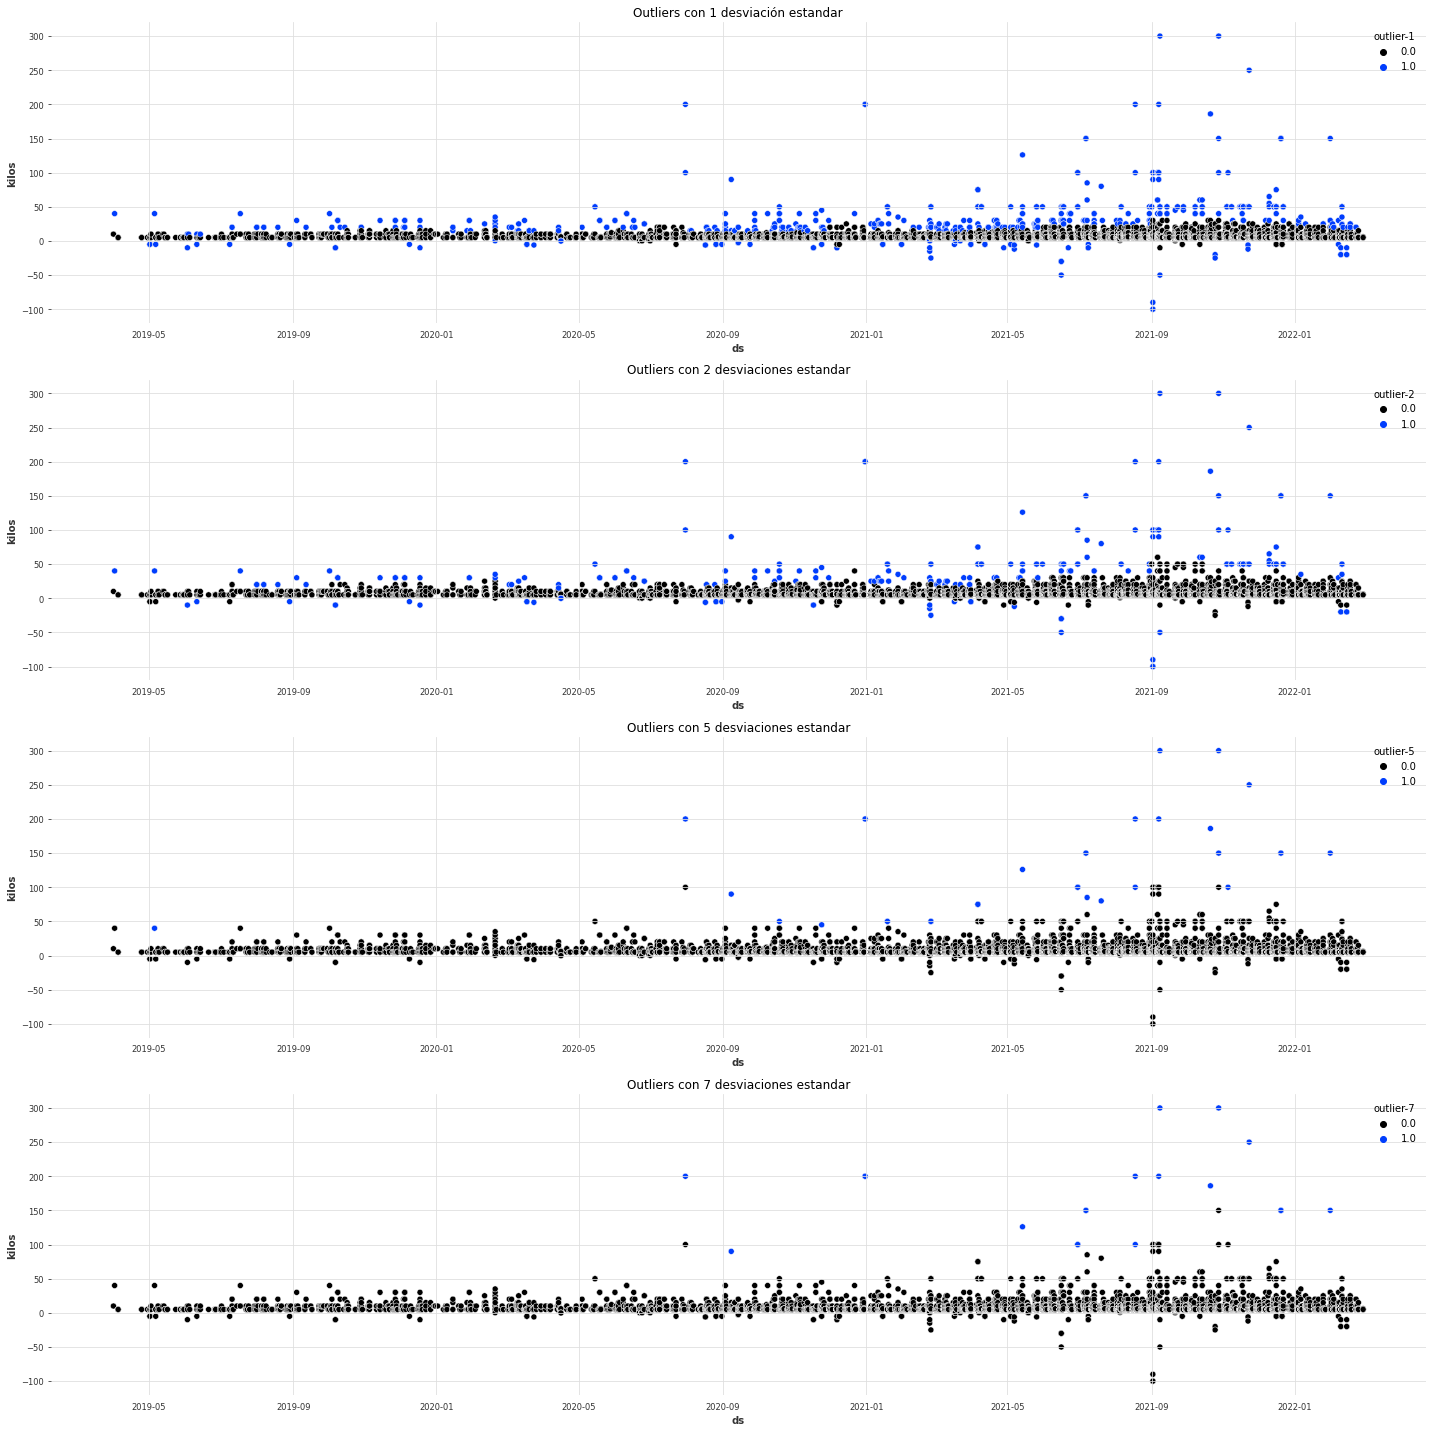

time: 2.47 s (started: 2022-03-12 18:13:03 -03:00)


In [22]:
# Graficamos los outliers en la serie de kilos
fig, ax = plt.subplots(4, 1,figsize=(20,20))
sns.scatterplot(df_clean['ds'], df_clean['kilos'], hue = df_clean['outlier-1'], ax=ax[0])
ax[0].set_title('Outliers con 1 desviación estandar', fontsize=12)
sns.scatterplot(df_clean['ds'], df_clean['kilos'], hue = df_clean['outlier-2'], ax=ax[1])
ax[1].set_title('Outliers con 2 desviaciones estandar', fontsize=12)
sns.scatterplot(df_clean['ds'], df_clean['kilos'], hue = df_clean['outlier-5'], ax=ax[2])
ax[2].set_title('Outliers con 5 desviaciones estandar', fontsize=12)
sns.scatterplot(df_clean['ds'], df_clean['kilos'], hue = df_clean['outlier-7'], ax=ax[3])
ax[3].set_title('Outliers con 7 desviaciones estandar', fontsize=12)
plt.tight_layout()

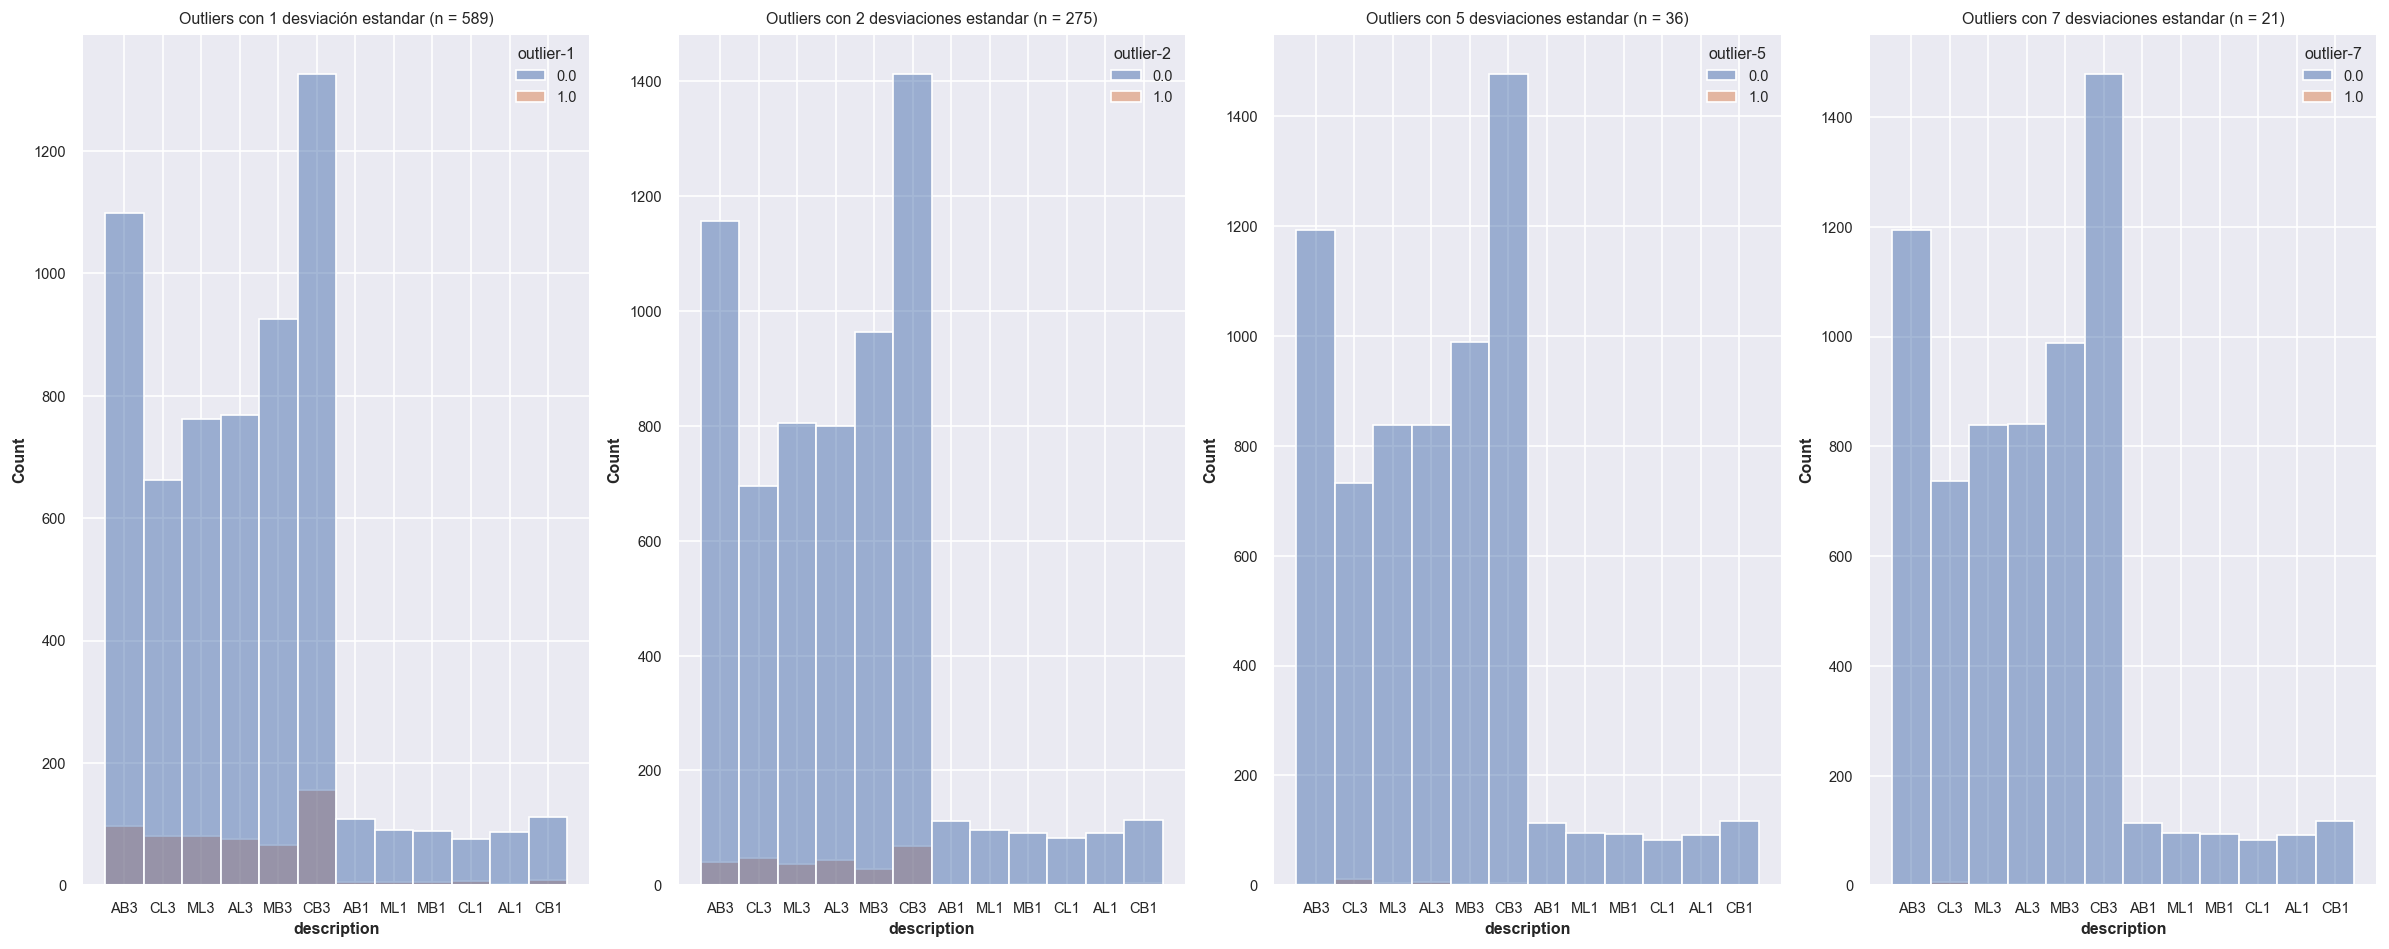

time: 1.16 s (started: 2022-03-12 18:22:43 -03:00)


In [66]:
# Graficamos el histograma de items con outliers
fig, ax = plt.subplots(1, 4,figsize=(20,8))
sns.histplot(data=df_clean, x='description', hue='outlier-1', ax=ax[0])
ax[0].set_title(f'Outliers con 1 desviación estandar (n = {df_clean[df_clean["outlier-1"] == 1].shape[0]})')
sns.histplot(data=df_clean, x='description', hue='outlier-2', ax=ax[1])
ax[1].set_title(f'Outliers con 2 desviaciones estandar (n = {df_clean[df_clean["outlier-2"] == 1].shape[0]})')
sns.histplot(data=df_clean, x='description', hue='outlier-5', ax=ax[2])
ax[2].set_title(f'Outliers con 5 desviaciones estandar (n = {df_clean[df_clean["outlier-5"] == 1].shape[0]})')
sns.histplot(data=df_clean, x='description', hue='outlier-7', ax=ax[3])
ax[3].set_title(f'Outliers con 7 desviaciones estandar (n = {df_clean[df_clean["outlier-7"] == 1].shape[0]})')
plt.tight_layout()

Usaremos entonces 7 desviaciones estandar desde la media para identificar outliers

In [24]:
# Vemos la distriución de datos sacados de la serie de kilos
df_clean['outlier-7'].value_counts()

0.0    6673
1.0      21
Name: outlier-7, dtype: int64

time: 0 ns (started: 2022-03-12 18:13:07 -03:00)


In [25]:
#Sacamos los outliers
df_clean_outliers = df_clean[df_clean['outlier-7'] == 0]


time: 16 ms (started: 2022-03-12 18:13:07 -03:00)


#### Filtrado de datos

Para mejorar nuestros modelos, hemos decidido sólo incluir la información desde Marzo 2020 en adelante. Esto debido a que el comportamiento del canal de televentas cambió drásticamente posterior esta fecha, debido a la pandemia y el distanciamento social, por lo que quitar los datos previos tiene sentido para nosotros y el cliente.

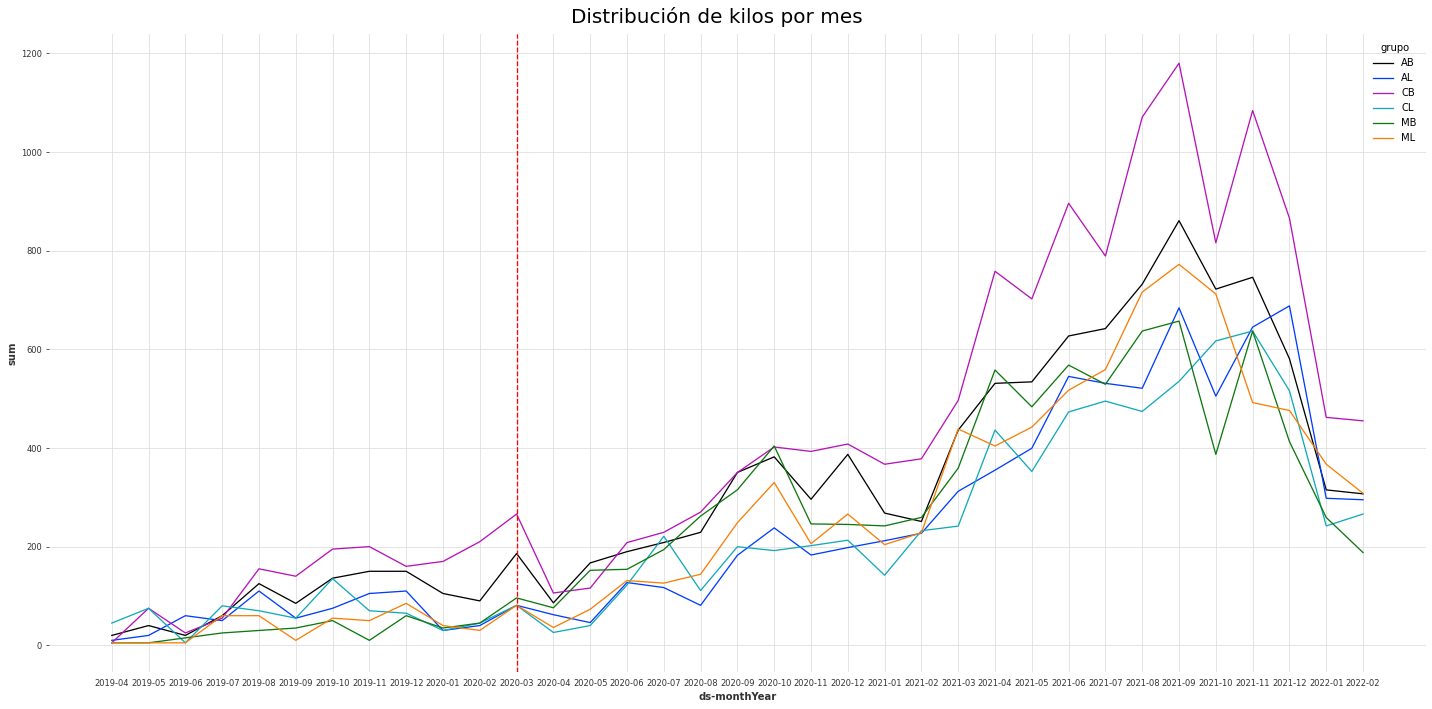

time: 797 ms (started: 2022-03-12 18:13:07 -03:00)


In [26]:
df_grouped_monthly = df_clean_outliers.sort_values(by=['ds']).groupby(['ds-monthYear', 'grupo']).agg({'kilos' : ['sum']})
df_grouped_monthly.columns = ['sum']
df_grouped_monthly.reset_index(inplace = True)
plt.figure(figsize=(20,10))
sns.lineplot(data=df_grouped_monthly, x='ds-monthYear', y='sum', hue='grupo')
plt.suptitle('Distribución de kilos por mes', fontsize=20)
plt.axvline(x='2020-03', color='r', linestyle='--')
plt.tight_layout()

In [27]:
# Dejamos sólo los datos de Marzo 2020 en adelante
df_clean_outliers = df_clean_outliers[df_clean_outliers['ds'] >= pd.to_datetime('2020-03-01')]

time: 0 ns (started: 2022-03-12 18:13:08 -03:00)


### Agrupación

Empezamos definiendo unas funciones helpers para procesar el código

In [28]:
# Transformamos las fechas de cada semana a pd.RangeIndex
def convertWeeklyIndex(df):
    cols = [*df.columns, 'month', 'year', 'weekOfYear']
    intDf = pd.DataFrame(columns=cols)
    # Desde 2019-13 a 2021-48 hay 134 semanas
    año = 2020
    semana = 9
    index = 1
    debugLabels = []
    while True:
        cero = '0' if semana < 10 else ''
        label = f'{año}-{cero}{semana}'
        fecha = pd.to_datetime(f'{label}-6', format='%Y-%U-%w')
        month = fecha.month
        year = fecha.year
        weekOfYear = fecha.strftime('%U')
        if label in df.index:
            intDf.at[index] = [*df.loc[label, :], *[month, year, weekOfYear]]
            debugLabels.append(label)
        else:
            print('weekly No encontrado', label, index)
            intDf.at[index] = [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, month, year, weekOfYear]
        if label == '2022-09':
            break
        index += 1
        semana += 1
        if semana > 52:
            año += 1
            if año == 2020:
                semana = 0
            else:
                semana = 1
    # Creamos un nuevo DataFrame con las fechas de las semanas
    newIndex = pd.RangeIndex(0, index)
    try :
        intDf.index = newIndex
    except:
        # Buscar el index en df que no esta en debugLabels
        notFound = list(filter(lambda x: x not in debugLabels, df.index))
        print(notFound)
    return intDf

# Transformamos las fechas de cada mes a pd.RangeIndex
def convertMonthlyIndex(df):
    cols = [*df.columns, 'month', 'year']
    intDf = pd.DataFrame(columns=cols)
    # Desde 2019-13 a 2021-48 hay 134 semanas
    año = 2020
    mes = 3
    index = 1
    debugLabels = []
    while True:
        cero = '0' if mes < 10 else ''
        label = f'{año}-{cero}{mes}'
        if label in df.index:
            intDf.at[index] = [*df.loc[label, :], *[mes, año]]
            debugLabels.append(label)
        else:
            print('monthly No encontrado', label, index)
            intDf.at[index] = [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, mes, año]
        if label == '2022-02':
            break
        index += 1
        mes += 1
        if mes > 12:
            mes = 1
            año += 1
    # Creamos un nuevo DataFrame con las fechas de las semanas
    newIndex = pd.RangeIndex(0, index)
    try :
        intDf.index = newIndex
    except:
        # Buscar el index en df que no esta en debugLabels
        notFound = list(filter(lambda x: x not in debugLabels, df.index))
        print(notFound)
    return intDf

time: 0 ns (started: 2022-03-12 18:13:08 -03:00)


In [29]:
# Funcion que recibe un Dataframe y retorna un objeto con los datos procesados en formato TimeSeries(darts) y df.
def preprocessSeries(subDf, freq = 'D', cols = ['kilos_sum', 'kilos_std', 'kilos_max', 'kilos_median']):
    filler = MissingValuesFiller(fill=0.)
    #Instanciamos
    itemTimeSeries = TimeSeries.from_dataframe(subDf, None, value_cols=cols, freq=freq)
    # Completamos valores faltantes
    itemTimeSeries = filler.transform(itemTimeSeries)
    # Separamos los datos en train y test
    train, test = itemTimeSeries.split_before(0.8)
    # Separamos las covariantes
    scaled_train_covs = concatenate(
        [
            train['kilos_max'],
            train['kilos_std'],
            train['kilos_median'],
        ],
        axis="component",
    )
    scaled_test_covs = concatenate(
        [
            test['kilos_max'],
            test['kilos_std'],
            test['kilos_median'],
        ],
        axis="component",
    )
    return {
        'df': subDf,
        'series': itemTimeSeries,
        'train': {
            'target': train['kilos_sum'],
            'past_covars': scaled_train_covs,
        },
        'test': {
            'target': test['kilos_sum'],
            'past_covars': scaled_test_covs,
        }
    }

time: 0 ns (started: 2022-03-12 18:13:08 -03:00)


#### Agrupaciones temporales

Se generarán los conjuntos de datos considerando:
1. División temporal con totalidad de productos: agrupación diaria, semanal y mensual.
2. División temporal por producto: considerando los 6 tipos de producto, se realizarán las mismas agrupaciones temporales de 1.

In [30]:
# Agrupamos según fecha diaria y grupo
groupedDailyDf = df_clean_outliers.groupby(['ds', 'grupo']).agg({'kilos': ['sum', 'max', 'min', 'mean', 'median', 'std']})
groupedDailyDf.columns = ['_'.join(col).strip() for col in groupedDailyDf.columns.values]
# Creamos un diccionario para guardar las series
series = {}
# Conseguimos según grupo
for itemCode in groupedDailyDf.index.get_level_values(1).unique():
    subDf = groupedDailyDf[groupedDailyDf.index.get_level_values(1) == itemCode].sort_values(by='ds')
    if(subDf.shape[0] > 1):
        subDf.index = subDf.index.droplevel(1)
        subDf = subDf.astype(float)
        processed_series = preprocessSeries(subDf, freq='D')
        # Agregamos los datos al diccionario
        series[itemCode] = processed_series
# Conseguimos los totales
groupedTotalDailyDf = df_clean_outliers.groupby(['ds']).agg({'kilos': ['sum', 'max', 'min', 'mean', 'median', 'std']})
groupedTotalDailyDf.columns = ['_'.join(col).strip() for col in groupedTotalDailyDf.columns.values]
groupedDailyDf = groupedTotalDailyDf.astype(float)
series['total'] = preprocessSeries(groupedTotalDailyDf, freq='D')


time: 203 ms (started: 2022-03-12 18:13:09 -03:00)


In [31]:
# Agrupamos por semana y grupo
groupedWeeklyDf = df_clean_outliers.groupby(['ds-weekYear', 'grupo']).agg({'kilos': ['sum', 'max', 'min', 'mean', 'median', 'std']})
groupedWeeklyDf.columns = ['_'.join(col).strip() for col in groupedWeeklyDf.columns.values]
# Iteramos por los grupos
weekly_series = {}
for itemCode in groupedWeeklyDf.index.get_level_values(1).unique():
    subDf = groupedWeeklyDf[groupedWeeklyDf.index.get_level_values(1) == itemCode].sort_values(by='ds-weekYear')
    if(subDf.shape[0] > 1):
        subDf.index = subDf.index.droplevel(1)
        # Convertimos los indices a pd.Int64Index
        subDf = convertWeeklyIndex(subDf).astype(float)
        processed_series = preprocessSeries(subDf, freq='W', cols=['kilos_sum', 'kilos_std', 'kilos_max', 'kilos_median', 'month', 'year', 'weekOfYear'])
        # Agregamos los datos al diccionario
        weekly_series[itemCode] = processed_series
# Agrupamos los totales semana
groupedTotalWeeklyDf = df_clean_outliers.groupby(['ds-weekYear']).agg({'kilos': ['sum', 'max', 'min', 'mean', 'median', 'std']})
groupedTotalWeeklyDf.columns = ['_'.join(col).strip() for col in groupedTotalWeeklyDf.columns.values]
# Convertimos a pd.Int64Index
groupedTotalWeeklyDf = convertWeeklyIndex(groupedTotalWeeklyDf).astype(float)
# Agregamos los datos al diccionario
weekly_series['total'] = preprocessSeries(groupedTotalWeeklyDf, freq='W', cols=['kilos_sum', 'kilos_std', 'kilos_max', 'kilos_median', 'month', 'year', 'weekOfYear'])

weekly No encontrado 2020-17 9
weekly No encontrado 2022-09 105
weekly No encontrado 2020-18 10
weekly No encontrado 2020-17 9
weekly No encontrado 2022-09 105
weekly No encontrado 2020-09 1
weekly No encontrado 2020-12 4
weekly No encontrado 2020-14 6
weekly No encontrado 2020-16 8
weekly No encontrado 2022-09 105
weekly No encontrado 2020-09 1
weekly No encontrado 2020-14 6
time: 672 ms (started: 2022-03-12 18:13:09 -03:00)


In [32]:
# Agrupamos según mes y grupo
groupedMonthlyDf = df_clean_outliers.groupby(['ds-monthYear', 'grupo']).agg({'kilos': ['sum', 'max', 'min', 'mean', 'median', 'std']})
groupedMonthlyDf.columns = ['_'.join(col).strip() for col in groupedMonthlyDf.columns.values]
monthly_series = {}
for itemCode in groupedMonthlyDf.index.get_level_values(1).unique():
    subDf = groupedMonthlyDf[groupedMonthlyDf.index.get_level_values(1) == itemCode].sort_values(by='ds-monthYear')
    if(subDf.shape[0] > 1):
        subDf.index = subDf.index.droplevel(1)
        # Convertimos los indices a pd.Int64Index
        subDf = convertMonthlyIndex(subDf).astype(float)
        processed_series = preprocessSeries(subDf, freq='M', cols=['kilos_sum', 'kilos_std', 'kilos_max', 'kilos_median', 'month', 'year'])
        # Agregamos los datos al diccionario
        monthly_series[itemCode] = processed_series
# Agrupamos los totales semana
groupedTotalMonthlyDf = df_clean_outliers.groupby(['ds-monthYear']).agg({'kilos': ['sum', 'max', 'min', 'mean', 'median', 'std']})
groupedTotalMonthlyDf.columns = ['_'.join(col).strip() for col in groupedTotalMonthlyDf.columns.values]
# Convertimos a pd.Int64Index
groupedTotalMonthlyDf = convertMonthlyIndex(groupedTotalMonthlyDf).astype(float)
# Agregamos los datos al diccionario
monthly_series['total'] = preprocessSeries(groupedTotalMonthlyDf, freq='M', cols=['kilos_sum', 'kilos_std', 'kilos_max', 'kilos_median', 'month', 'year'])


time: 203 ms (started: 2022-03-12 18:13:10 -03:00)


### Variables Exogenas

#### Temperatura
Fuente: Dirección General de Aeronáutica Civil (DGAC), Dirección Meteorológica de Chile, Servicios Climáticos, temperatura media diaria en grados Celsius de Estación Quinta Normal (Región Metropolitana).

Diario: temperatura
Semanal y mensual: promedio de temperatura media de días correspondientes.

In [33]:
df_temperature_week = pd.DataFrame(df_temperature.groupby([pd.Grouper(key = 'fecha', freq = 'W-MON', label = 'left')])['temperatura_media'].mean())
df_temperature_month = pd.DataFrame(df_temperature.groupby([pd.Grouper(key = 'fecha', freq = 'M', label = 'left')])['temperatura_media'].mean())

time: 0 ns (started: 2022-03-12 18:13:10 -03:00)


In [34]:
#df_temperature_week y df_temperature_week ya tienen fecha como índice por la agrupación de la celda anterior
df_temperature.set_index('fecha', inplace = True)

time: 0 ns (started: 2022-03-12 18:13:10 -03:00)


## Exploratorio

### Análisis de correlación cruzada

<AxesSubplot:>

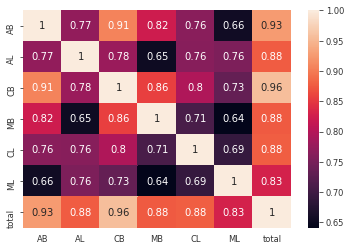

time: 640 ms (started: 2022-03-12 18:13:10 -03:00)


In [35]:
# Hacemos un análisis de correlación entre grupos para la granularidad semanal
df_all_series = pd.DataFrame()
for key in weekly_series.keys():
  df_all_series[key] = weekly_series[key]['df']['kilos_sum']

sns.heatmap(df_all_series.corr(), annot=True)


Notamos que para casi todos las series por grupo tienen una correlación > ~0.83 respecto de la serie total, lo que nos permite ajustar nuestros modelos respecto a la serie total (con todos los productos) y replicarlos para cada grupo posteriormente.

### Exploración de las series

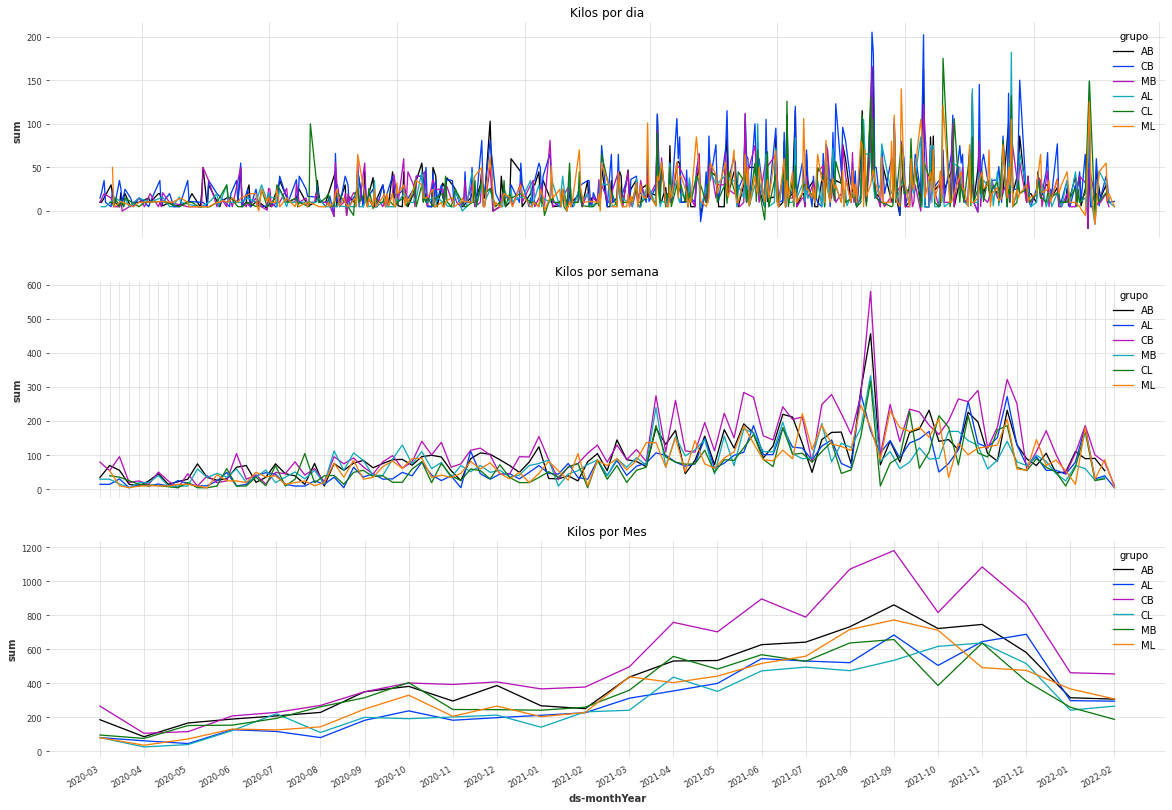

time: 1.31 s (started: 2022-03-12 18:13:11 -03:00)


In [37]:
# Graficaremos la venta total de kilos para cada granularidad de tiempo
fig, ax = plt.subplots(3, 1,figsize=(20,15))
# Diario
df_grouped_daily = df_clean_outliers.sort_values(by=['ds']).groupby(['ds', 'grupo']).agg({'kilos' : ['sum']})
df_grouped_daily.columns = ['sum']
df_grouped_daily.reset_index(inplace = True)
# Semanal
df_grouped_weekly = df_clean_outliers.sort_values(by=['ds']).groupby(['ds-weekYear', 'grupo']).agg({'kilos' : ['sum']})
df_grouped_weekly.columns = ['sum']
df_grouped_weekly.reset_index(inplace = True)
# Mensual
df_grouped_monthly = df_clean_outliers.sort_values(by=['ds']).groupby(['ds-monthYear', 'grupo']).agg({'kilos' : ['sum']})
df_grouped_monthly.columns = ['sum']
df_grouped_monthly.reset_index(inplace = True)
# Graficamos
sns.lineplot(data=df_grouped_daily, x='ds', y='sum', hue='grupo', ax=ax[0])
sns.lineplot(data=df_grouped_weekly, x='ds-weekYear', y='sum', hue='grupo', ax=ax[1])
sns.lineplot(data=df_grouped_monthly, x='ds-monthYear', y='sum', hue='grupo', ax=ax[2])
ax[0].set_title('Kilos por dia')
ax[1].set_title('Kilos por semana')
ax[2].set_title('Kilos por Mes')
fig.autofmt_xdate()

Vemos que la agrupación Diaria es la que presenta mayor variabilidad, por lo que la descartaremos en los siguientes análisis.
Vemos también que la granularidad Mensual es mas estable en su variabilidad, pero presenta menos datos debido a la agrupación, lo que hace mas difícil el entrenamiento de modelos. Mientras, la granularidad semanal se presenta como un buen punto medio para mantener tanto variabilidad como cantidad de puntos, sin embargo igual presenta una volatilidad importante al final de la serie, asi como puntos con valores '0' para ciertos grupos.

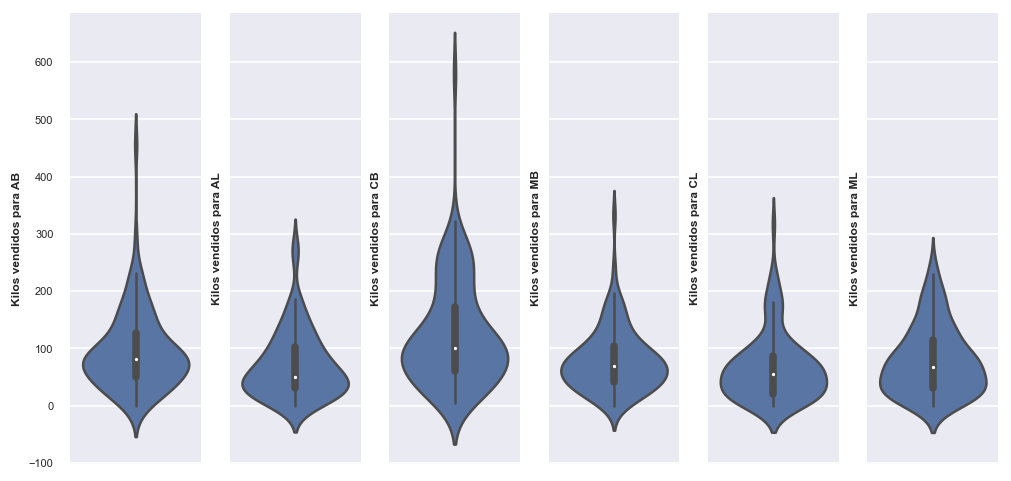

time: 469 ms (started: 2022-03-12 18:13:13 -03:00)


In [38]:
# Graficamos la distibución de cantidad de kilos por venta
sns.set(font_scale = 0.6)
plt.rcParams["figure.dpi"] = 120
fig, ax = plt.subplots(1, 6, figsize=(10, 5), sharey=True)
for n, i in enumerate(weekly_series.keys()):
    if i == 'total':
        continue
    axis = ax[n]
    df = weekly_series[i]['df']
    sns.violinplot(data = df, y = df['kilos_sum'], ax=axis)
    axis.set_ylabel(f'Kilos vendidos para {i}')

Respecto a la dsitribución de los datos:

- Los productos AB y CB tienen mayor dispersión de venta.
- Los productos M de ambos tipos son los que tienen, en conjunto, una mayor concentración en valores bajos.
- La distribución de venta del producto CB tiene transacciones con mayor cantidad de kilos con respecto a los otros productos (La mediana es mayor al resto asi como el punto donde comienza el tercer cuartil).
- Se observa que los productos con cobertura L, son los que presentan menor dispersión.

In [39]:
from scipy.stats import skew, kurtosis

for n, i in enumerate(weekly_series.keys()):
    df = weekly_series[i]['df']
    print(f'Conjunto de datos {i}, coeficiente de asimetría: ', round(skew(df['kilos_sum']), 2), '| Curtosis: ', round(kurtosis(df['kilos_sum']), 2))

Conjunto de datos AB, coeficiente de asimetría:  1.86 | Curtosis:  6.27
Conjunto de datos AL, coeficiente de asimetría:  1.36 | Curtosis:  2.07
Conjunto de datos CB, coeficiente de asimetría:  1.56 | Curtosis:  4.35
Conjunto de datos MB, coeficiente de asimetría:  1.49 | Curtosis:  3.75
Conjunto de datos CL, coeficiente de asimetría:  1.52 | Curtosis:  2.75
Conjunto de datos ML, coeficiente de asimetría:  0.82 | Curtosis:  -0.04
Conjunto de datos total, coeficiente de asimetría:  1.26 | Curtosis:  2.31
time: 16 ms (started: 2022-03-12 18:13:13 -03:00)


Respecto al coeficiente de asimetría y curtosis (Fischer) para los conjuntos semanales, se tiene:
- Todos los coeficientes de asimetría son mayores a 0: todas las distribuciones tienen concentración de valores mayores a la media, que es empujada con ciertos valores de anulaciones y ventas bajas. La asimetría de la curva total es cercana a 1.3, recogiendo la variabilidad de todos los productos.
- En relación a la curtosis, casi todos los índices son mayores a 0; estas curvas son leptocúrticas, con una gran concentración de valores en las cercanías a la media de cada producto. Existen diferencias importantes entre productos: en el caso del producto ML presenta la curtosis más cercana a 0, más parecida a una distribución normal, y se destaca el producto AB ya que presenta una curtosis muy alta.


## Análisis relacionados con series de tiempo

Graficamos la ACF y PCF para los 3 tipos de granularidad

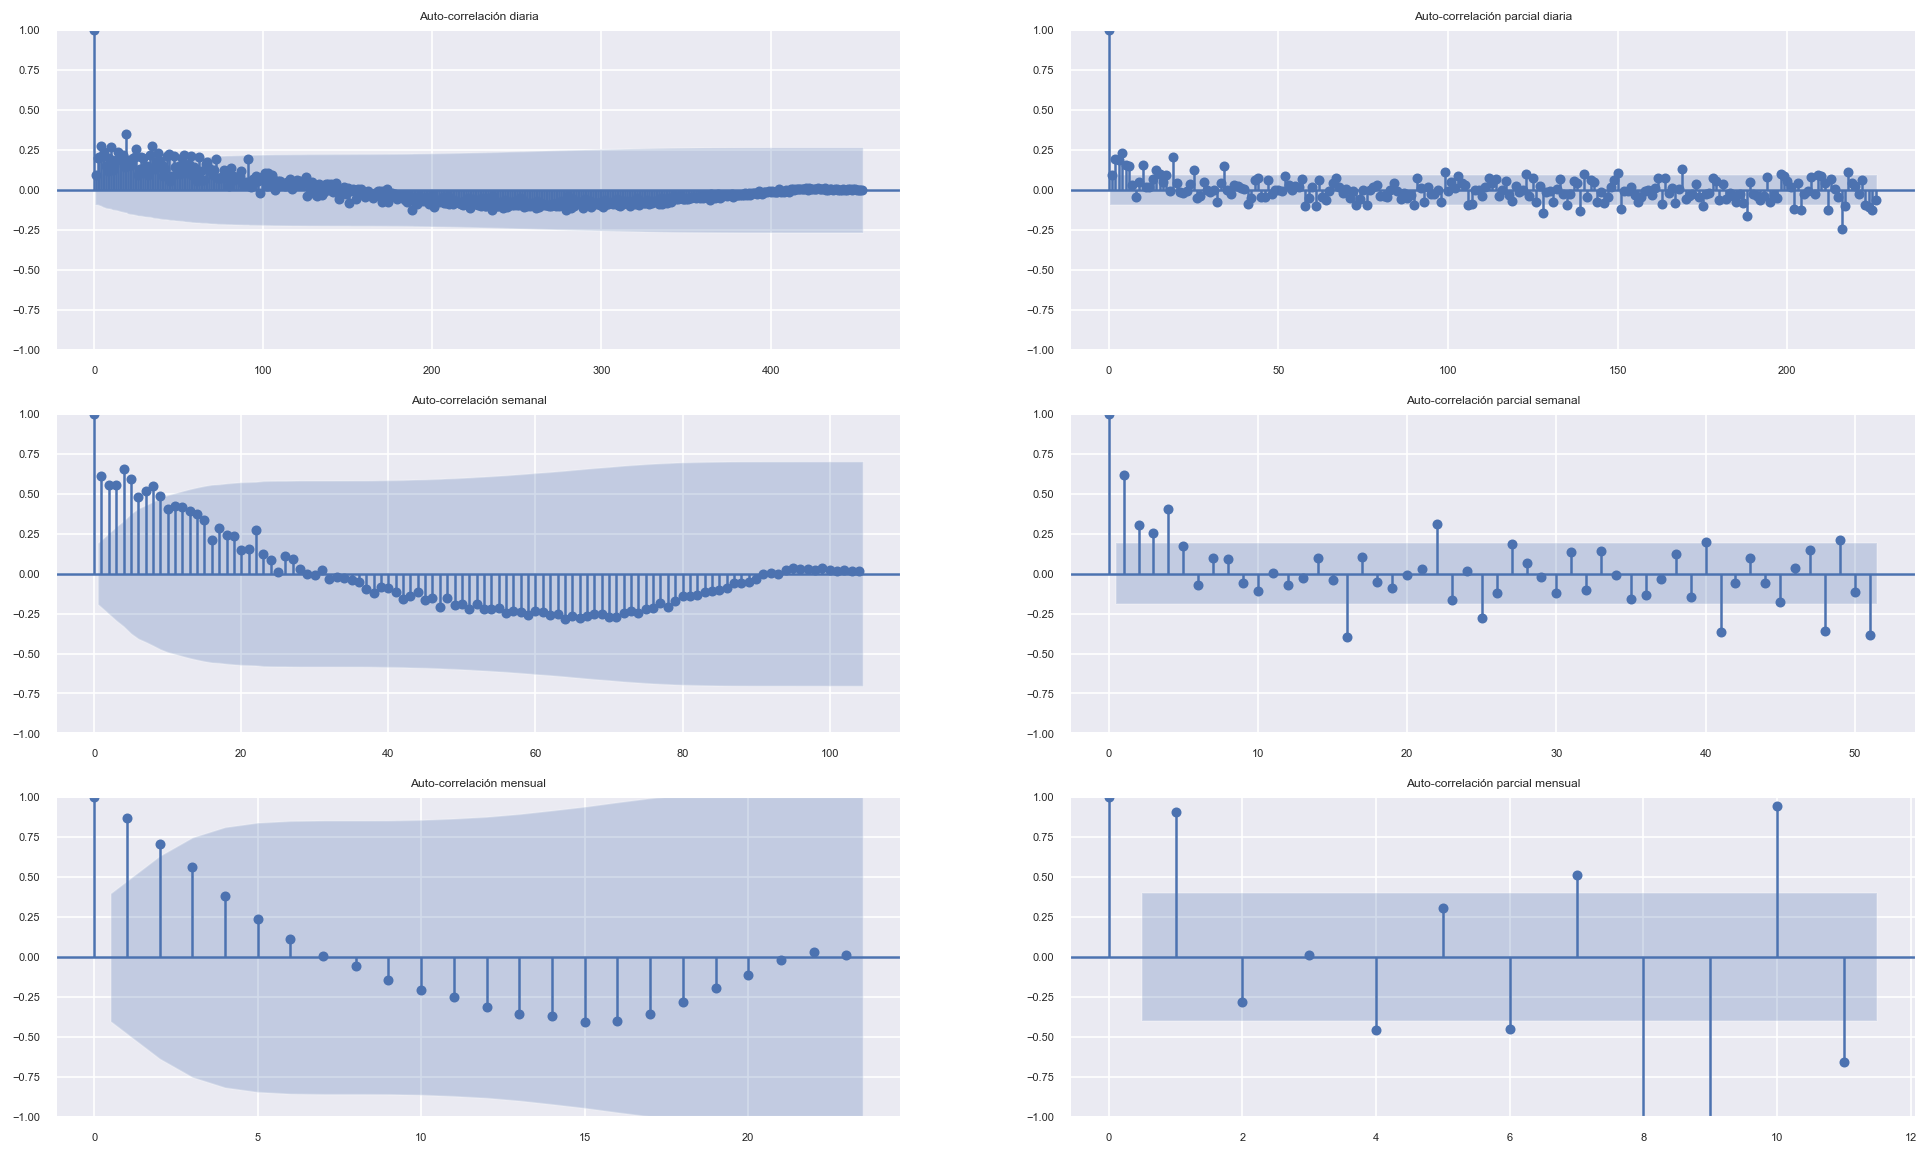

time: 1.19 s (started: 2022-03-12 18:13:14 -03:00)


In [40]:
# Graficamos
fig, ax = plt.subplots(3, 2, figsize = (20, 12))
for i, ts in enumerate([series['total']['df']['kilos_sum'], weekly_series['total']['df']['kilos_sum'], monthly_series['total']['df']['kilos_sum']]):
    plot_acf(ts, ax=ax[i][0], lags=int(len(ts)) - 1)
    plot_pacf(ts, ax=ax[i][1], lags=int(len(ts)*.5) - 1)
ax[0][0].set_title('Auto-correlación diaria')
ax[0][1].set_title('Auto-correlación parcial diaria')
ax[1][0].set_title('Auto-correlación semanal')
ax[1][1].set_title('Auto-correlación parcial semanal')
ax[2][0].set_title('Auto-correlación mensual')
ax[2][1].set_title('Auto-correlación parcial mensual');

## Decomposición Estacional

In [68]:
# Verificamos cuantas semanas tienen 0
dataframe = weekly_series['total']['series']['kilos_sum'].pd_dataframe()
weekWithZero = 0
for i in range(len(dataframe)):
    if (i + 1) not in dataframe.index:
        weekWithZero += 1
print(weekWithZero)

1
time: 0 ns (started: 2022-03-12 19:09:00 -03:00)


Vemos que sólo hay una semana que tiene 0 kilos vendidos, pero sabemos es sólo al inicio por lo que continuamos con la descomposición.

Creamos una función helper para buscar la frequencia estacional cuyos residuos sean lo mas parecido a una distribución normal.

In [42]:
# Función que recive una serie y una lista de frecuencias y retorna la mejor combinación de series de tendencia, estacionalidad y residuos en base a la normalidad de estos ultimos.
def plotSeasonalitySearch(serie, freqs, model_mode = ModelMode.ADDITIVE):
    bestFreq = 0
    bestScore = 0
    bestModels = (None, None, None)
    for freq in freqs:
        # Extraemos la tendencia y la estacionalidad
        trend, season = extract_trend_and_seasonality(serie, freq=freq, model=model_mode)
        # Calculamos los residuos
        residuals = remove_from_series(serie, trend, model_mode)
        residuals = remove_from_series(residuals, season, model_mode)
        # Analizamos la normalidad de los residuos
        k2, pvalue = normaltest(residuals.values())
        if(pvalue > bestScore):
            bestScore = pvalue
            bestFreq = freq
            bestModels = (trend, season, residuals)
    trend, season, residuals = bestModels
    # Graficamos
    fig, ax = plt.subplots(3, 1, figsize = (15, 10), sharex=True)
    fig.suptitle(f'Best model for series, best freq: {bestFreq}, best score: {bestScore}')
    trend.plot(ax=ax[0])
    ax[0].set_title('Tendencia')
    season.plot(ax=ax[1])
    ax[1].set_title('Estacionalidad')
    residuals.plot(ax=ax[2])
    ax[2].set_title(f'Residuos')
    fig.autofmt_xdate()
    plt.tight_layout();
    return bestModels

time: 16 ms (started: 2022-03-12 18:13:15 -03:00)


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


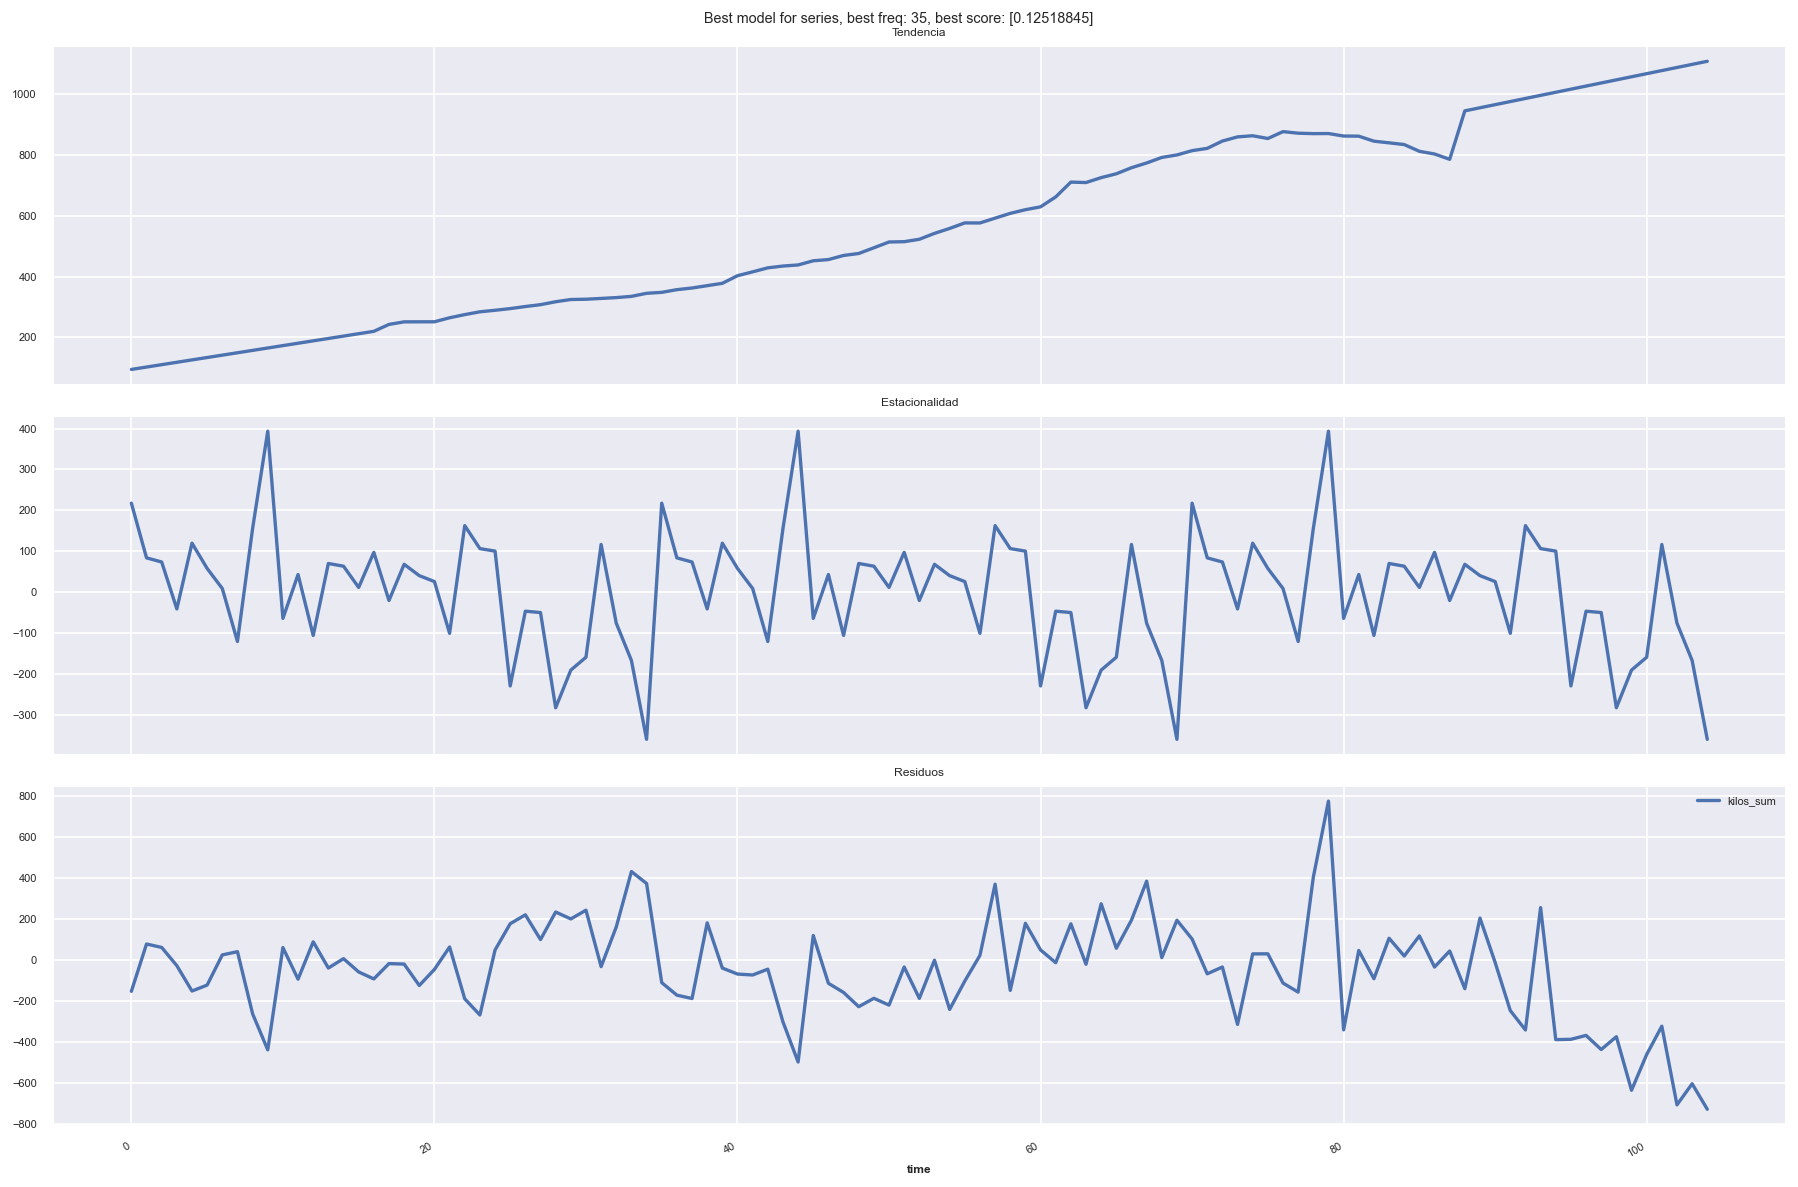

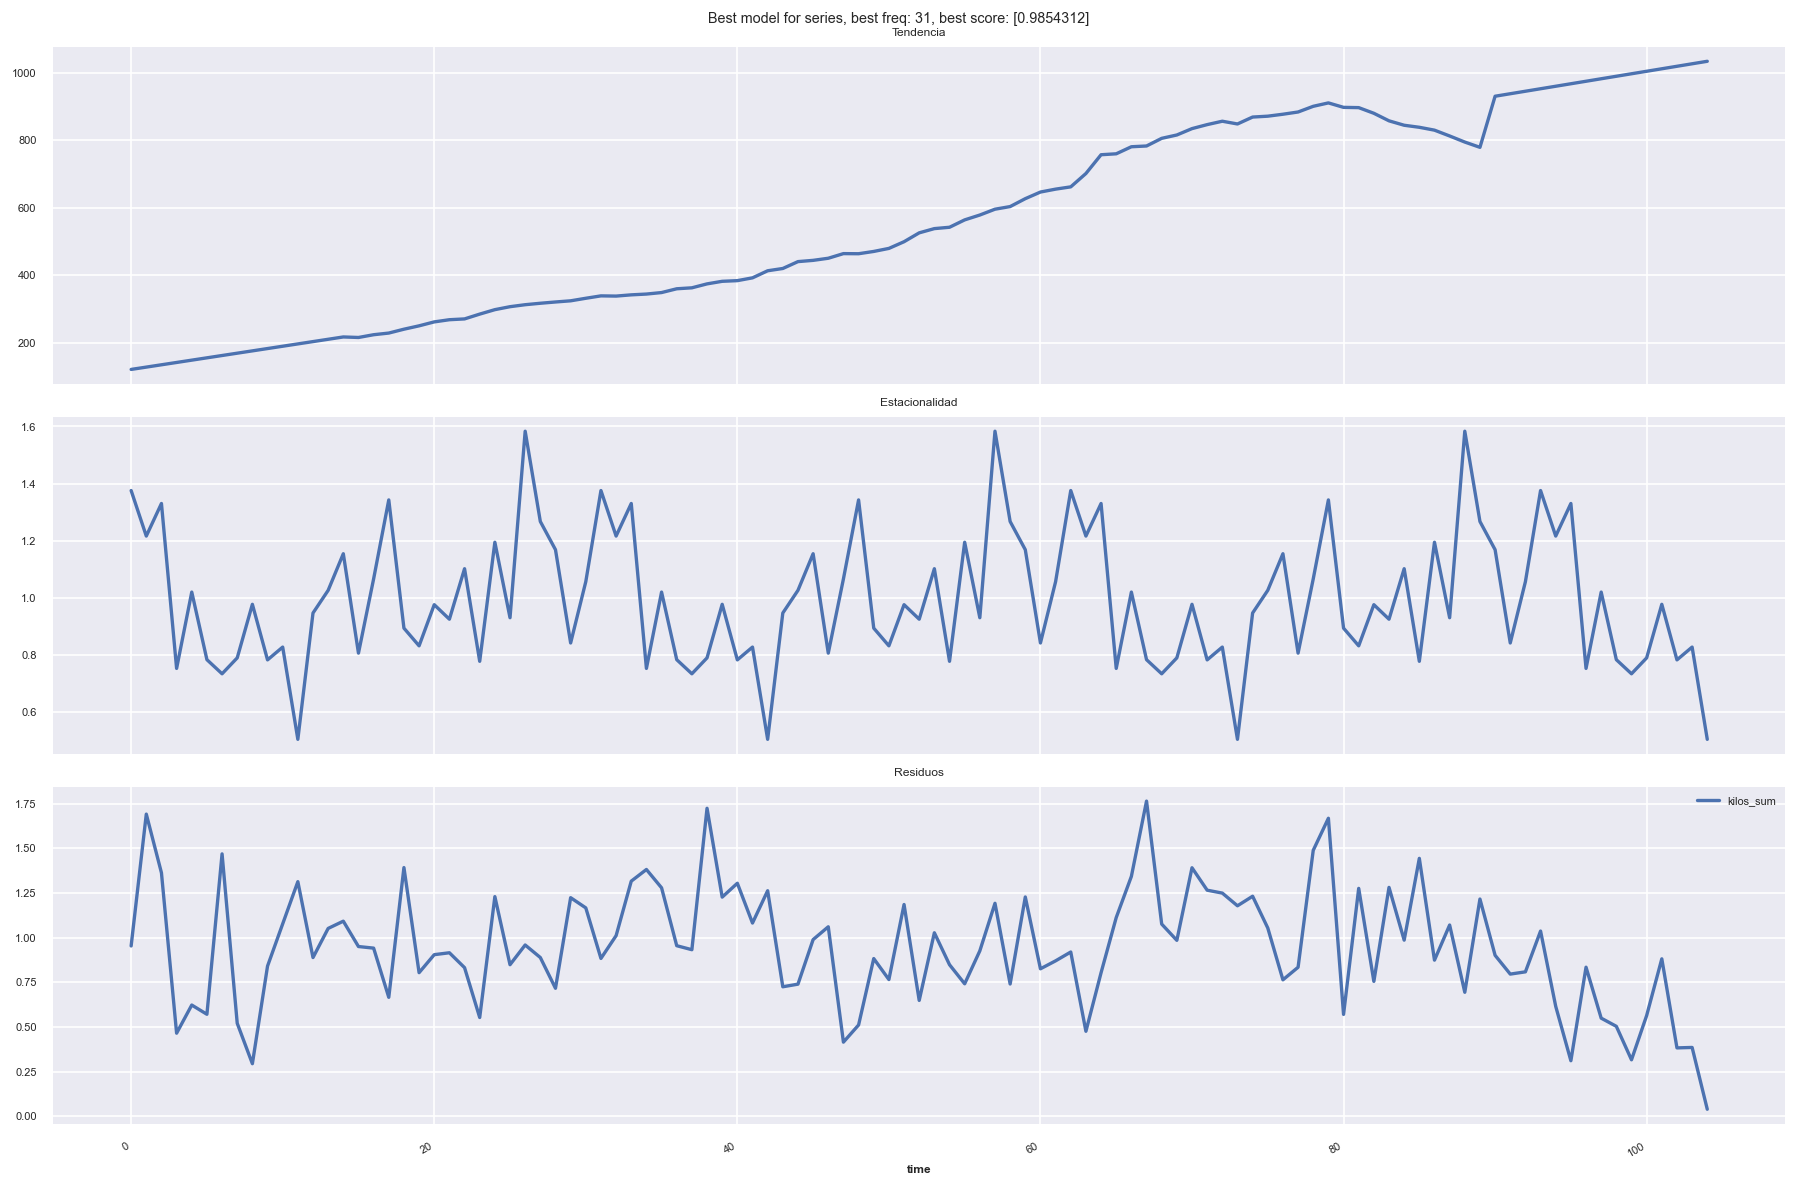

time: 1.7 s (started: 2022-03-12 18:13:15 -03:00)


In [43]:
# Buscamos la mejor frequencia para el modelo
trend, season, residuals = plotSeasonalitySearch(weekly_series['total']['series']['kilos_sum'], np.arange(1, 52), model_mode = ModelMode.ADDITIVE)
multiplicative_trend, multiplicative_season, multiplicative_residuals = plotSeasonalitySearch(weekly_series['total']['series']['kilos_sum'], np.arange(1, 52), model_mode = ModelMode.MULTIPLICATIVE)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


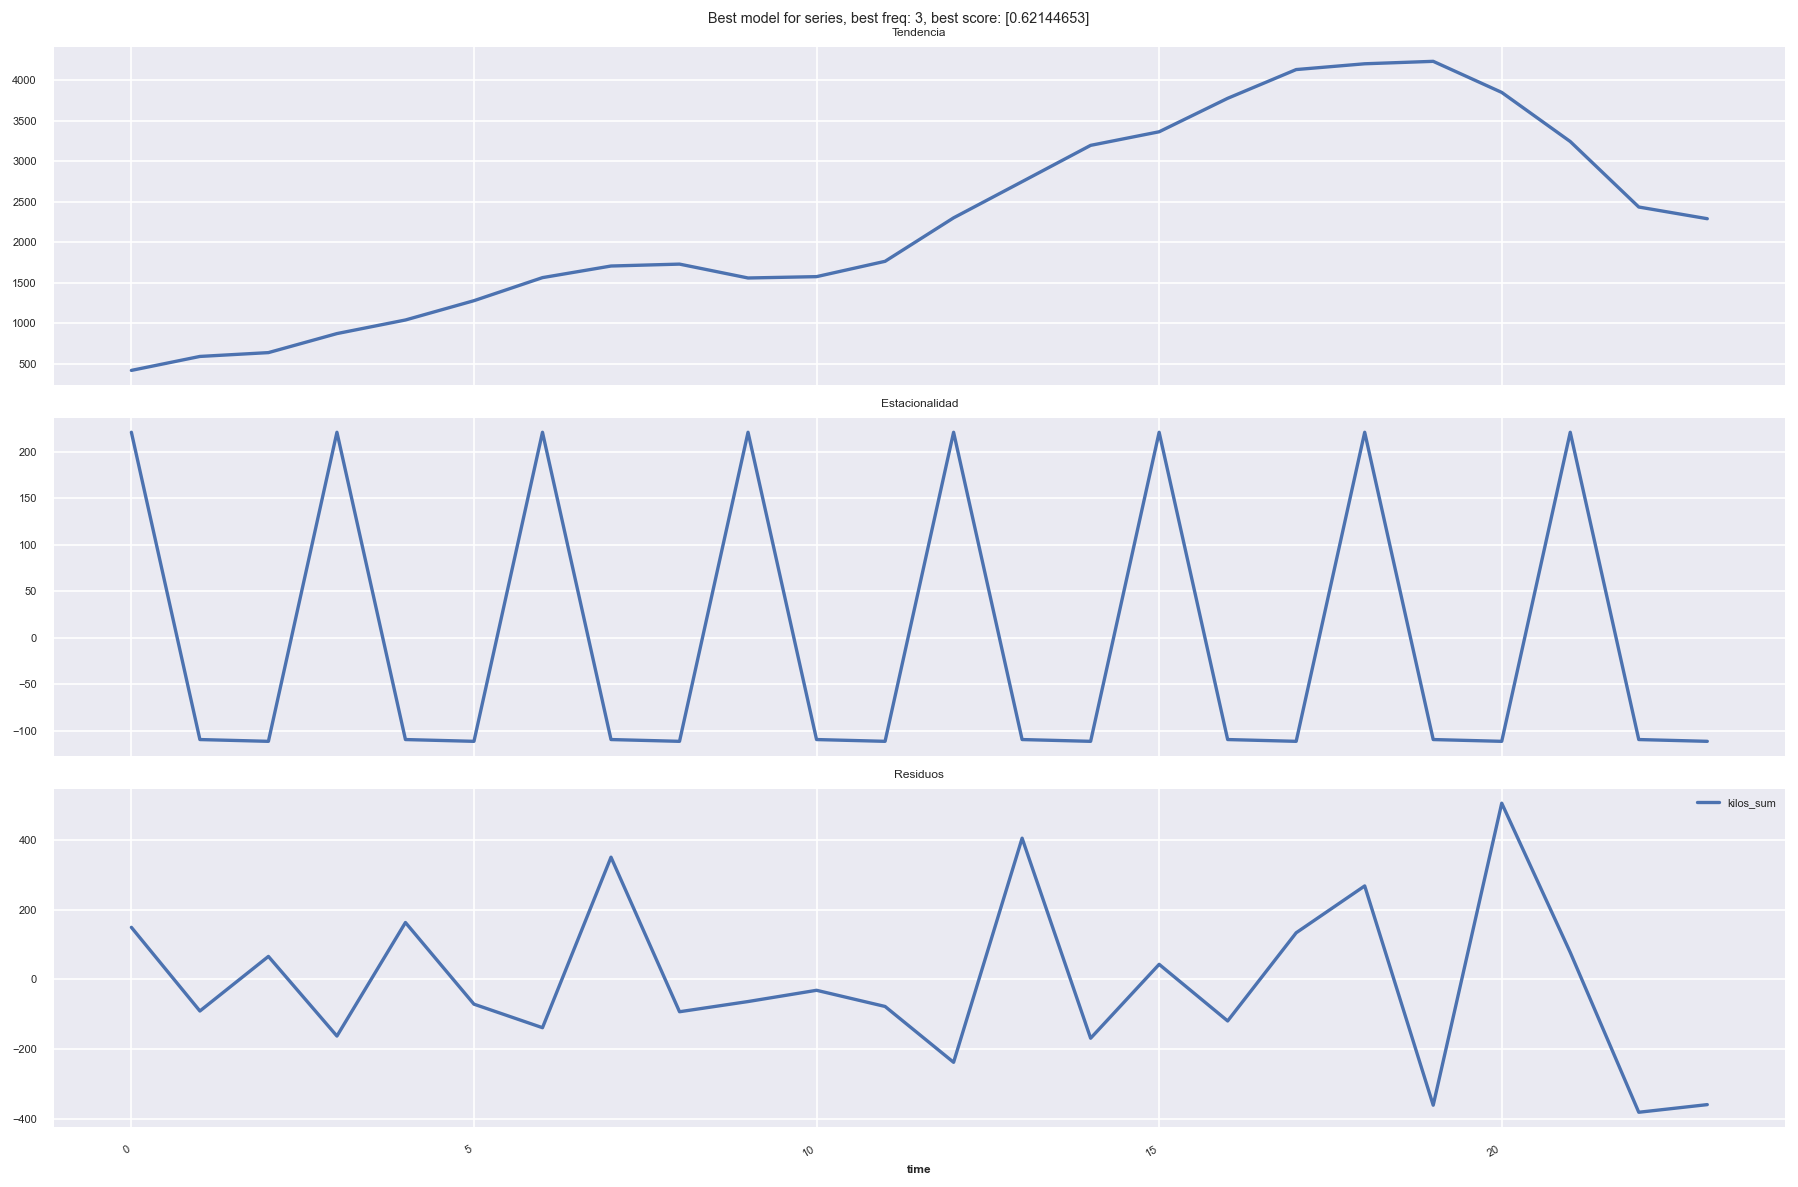

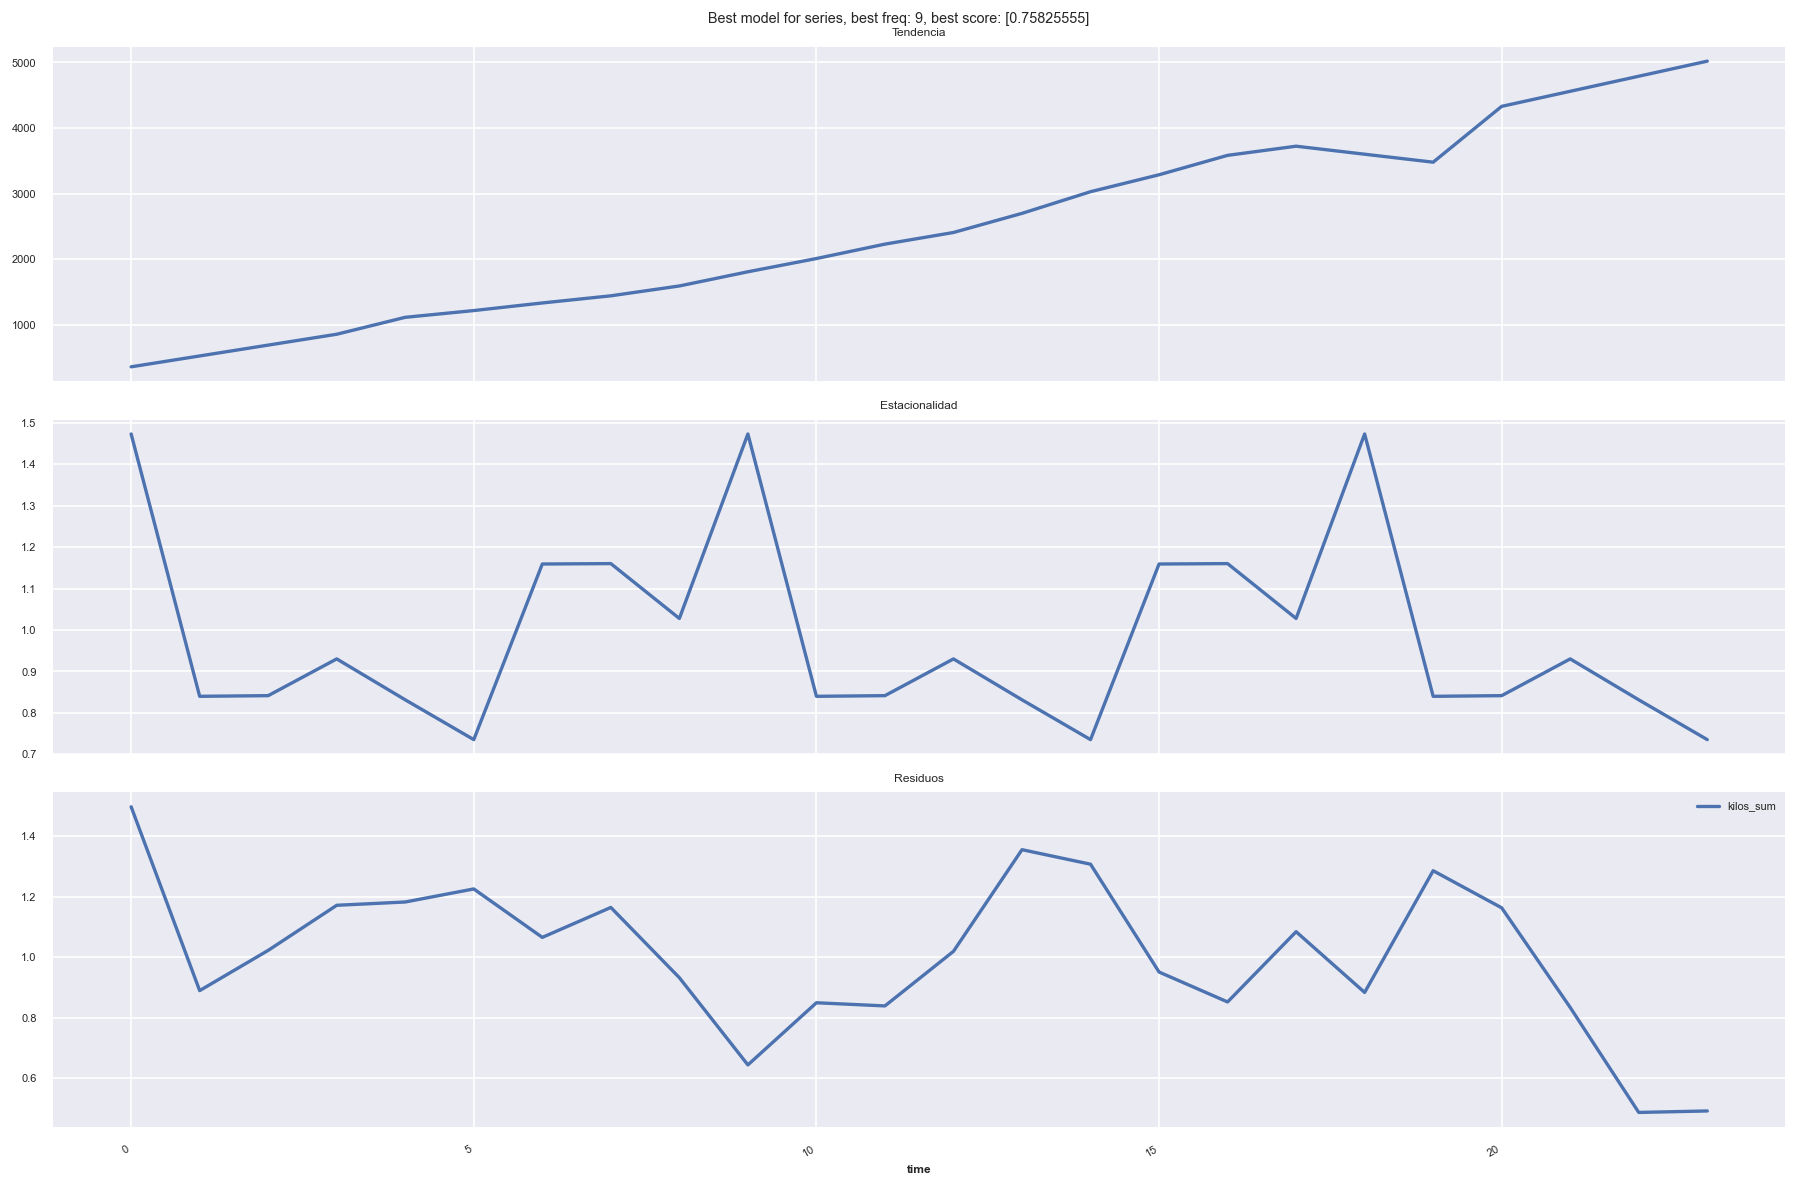

time: 1.2 s (started: 2022-03-12 18:13:17 -03:00)


In [44]:
monthly_trend, monthly_season, monthly_residuals = plotSeasonalitySearch(monthly_series['total']['series']['kilos_sum'], np.arange(1, 12), model_mode = ModelMode.ADDITIVE)
multiplicative_monthly_trend, multiplicative_monthly_season, multiplicative_monthly_residuals = plotSeasonalitySearch(monthly_series['total']['series']['kilos_sum'], np.arange(1, 12), model_mode = ModelMode.MULTIPLICATIVE)

Al realizar la busqueda de la mejor frecuencia para las granularidades semana y mensual, vemos que ninguna de las mejores combinaciones presenta un modelo lo suficientemente bueno (p-valor < 0.05). Concluímos asi que no hay ningún ajuste de tendencia y estacionalidad lo suficientemente bueno para continuar el análisis.

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


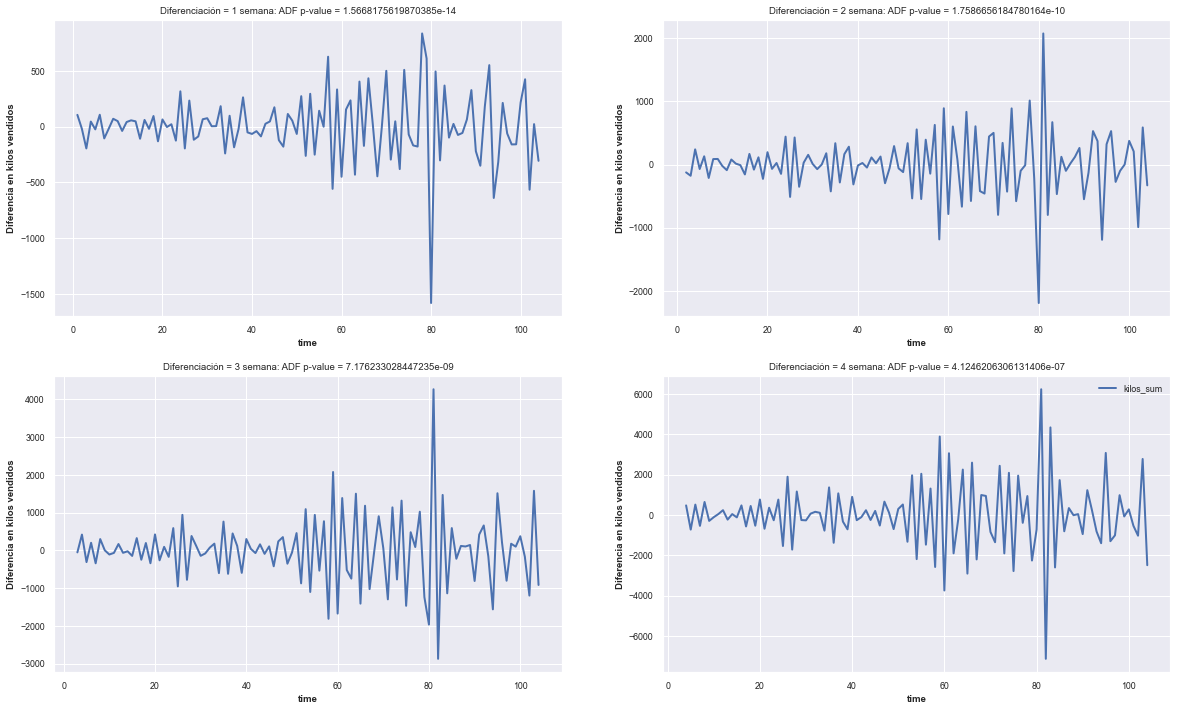

time: 844 ms (started: 2022-03-12 19:22:10 -03:00)


In [73]:
sns.set(font_scale = 0.8)
fig, ax = plt.subplots(2, 2, figsize = (20, 12))
ax = ax.flatten()
for i in range(4):
    diffSeries = weekly_series['total']['series']['kilos_sum'].diff(i + 1)
    adf_stats = stationarity_test_adf(diffSeries)
    diffSeries.plot(ax=ax[i])
    ax[i].set_title(f'Diferenciación = {i + 1} semana: ADF p-value = {adf_stats[1]}')
    ax[i].set_ylabel('Diferencia en kilos vendidos')

Vemos que al probar distintas diferenciaciones para la serie original, logramos obtener series que ya no presentan tendencia creciente.
Si comparamos los p-valores del test ADF, podemos ver que es posible convertir la serie original en una estacionaria usando lags >= 1.

## Modelos

Luego de la exploración de atributos, hemos decidido testear con los siguiente modelos:

1. ARIMA
2. Regresión Lineal
3. Fast Fourier Transform


### ARIMA

Hacemos un análisis de ACF y PCF para la diferenciación de 2

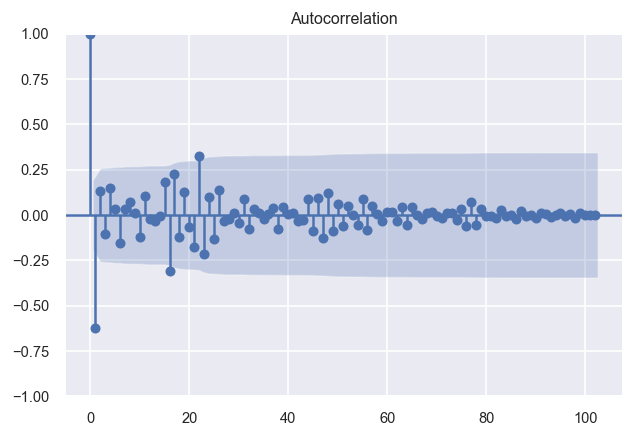

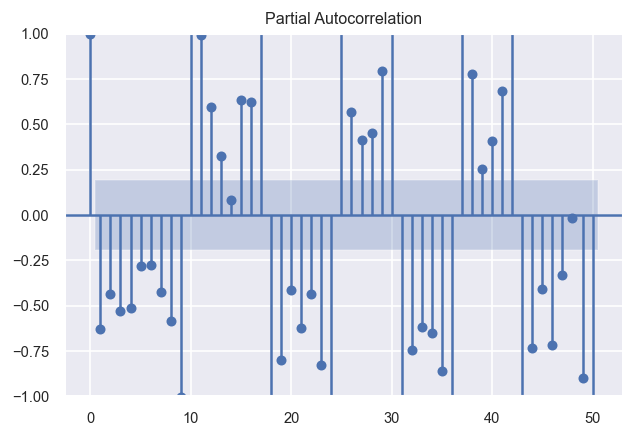

time: 500 ms (started: 2022-03-12 18:13:20 -03:00)


In [47]:
diff2 = weekly_series['total']['series']['kilos_sum'].diff(2).pd_dataframe()
plot_acf(diff2, lags=len(diff2) - 1);
plot_pacf(diff2, lags=int(len(diff2)*.5) - 1);

Vemos que la Autocorrelación se disipa rápidamente, y la PACF presenta valores absolutos siempre sobre ~0.25. Es por eso que concluímos que la parte MA de un modelo ARIMA aportará nula o negativamente en el desempeño del modelo.

In [76]:
# Separamos nuestra serie para continuar el entrenamiento
train, test = train_test_split(weekly_series['total']['series'], test_size=0.2)
print(len(train), len(test))

84 21
time: 0 ns (started: 2022-03-12 19:32:51 -03:00)


In [77]:
# Definimos un modelo ARIMA 
base_arima = ARIMA(p=9, d=2, q=0)
# Entrenamos usando el modelo ARIMA y la covariante del número de semana.
base_arima.fit(train['kilos_sum'], future_covariates=weekly_series['total']['series']['weekOfYear'])
preds = base_arima.predict(len(test['kilos_sum']), future_covariates=weekly_series['total']['series']['weekOfYear'])

time: 422 ms (started: 2022-03-12 19:32:57 -03:00)


In [78]:
# Verificamos la cantidad de kilos totales para el periodo
test['kilos_sum'].pd_dataframe().sum() - preds.pd_dataframe().sum()

component
kilos_sum   -2862.815179
dtype: float64

time: 0 ns (started: 2022-03-12 19:33:00 -03:00)


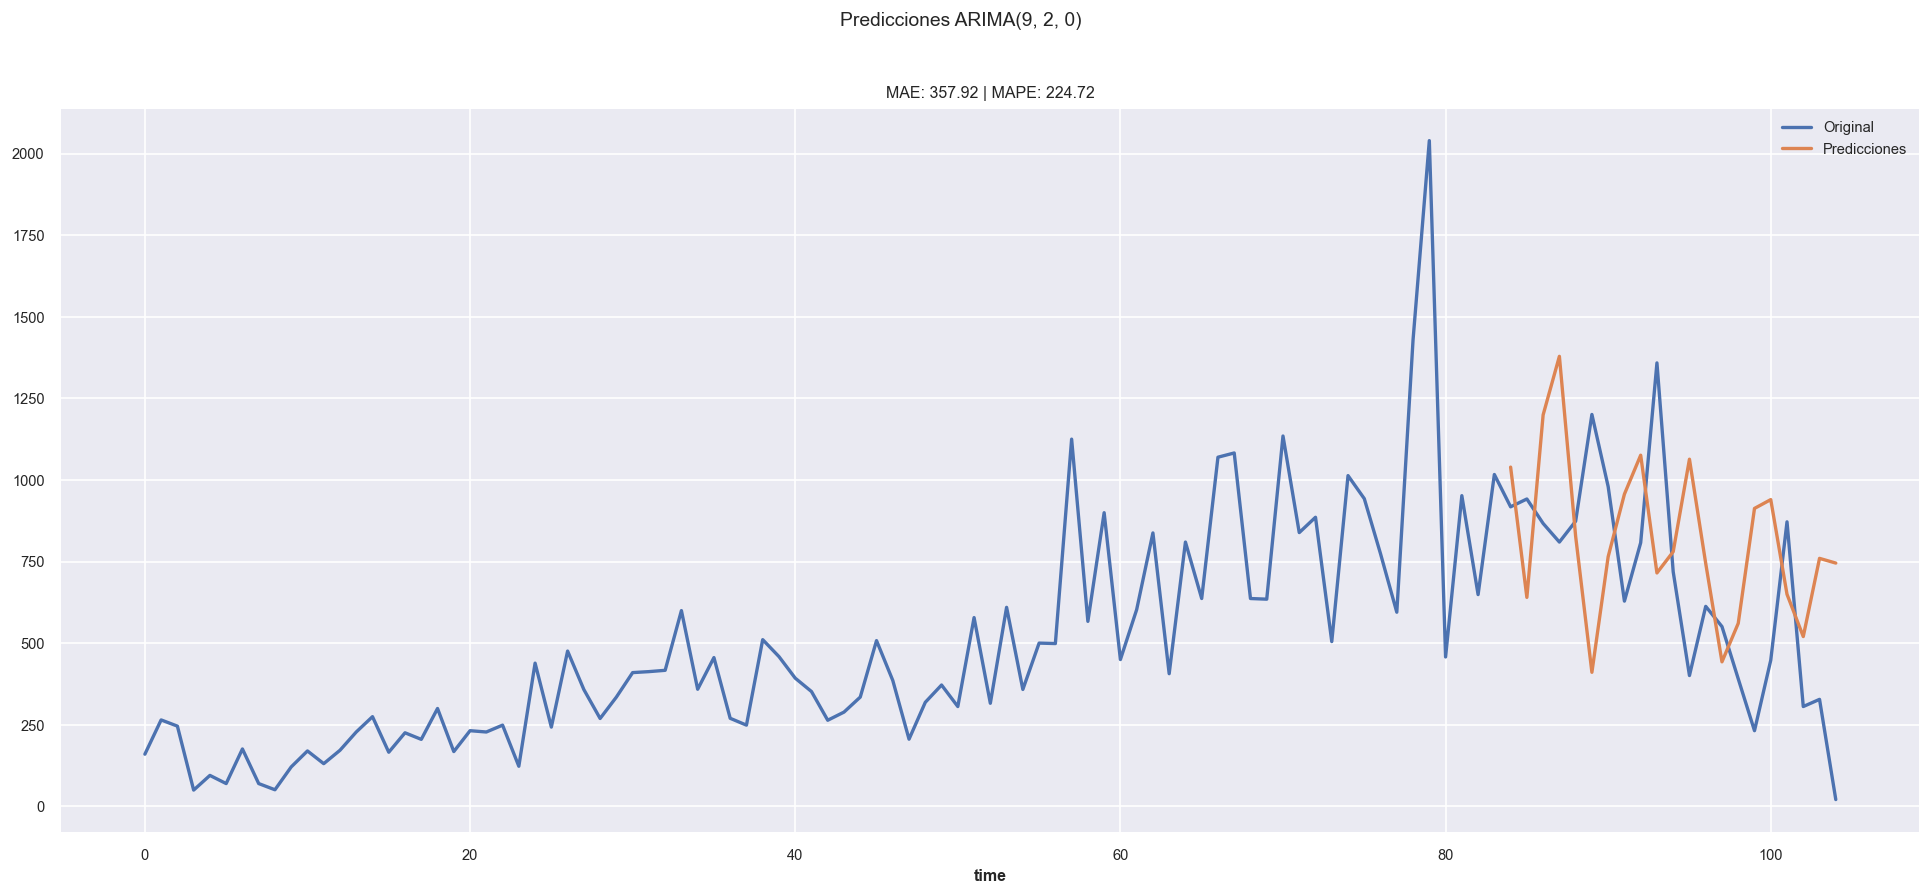

time: 312 ms (started: 2022-03-12 18:13:21 -03:00)


In [51]:
# Conseguimos las metricas de error
prediction_mae = mae(test['kilos_sum'], preds)
prediction_mape = mape(test['kilos_sum'], preds)
# Graficamos
plt.figure(figsize=(20, 8))
weekly_series['total']['series']['kilos_sum'].plot(label='Original')
preds.plot(label='Predicciones')
plt.suptitle('Predicciones ARIMA(9, 2, 0)')
plt.title('MAE: ' + str(round(prediction_mae, 2)) + ' | MAPE: ' + str(round(prediction_mape, 2)));

Vemos que al hacer Forecasting con estos parámetro logramos acercarnos bastante a la curva objetivo. Es necesario notar que como predecimos usando Forecasting, las predicciones mas lejanas al horizonte de entrenamiento tienden a tener un mayor margen de error.

Por ello continuaremos haciendo un Rolling Prediction usando el mismo set de parámetros.

In [52]:
# Hacemos un rolling prediction para el ARIMA
pred = []
for i in range(len(test)):
    base_arima = ARIMA(p=9, d=2, q=0)
    train_aux = weekly_series['total']['series']['kilos_sum'][0: 84 + i]
    base_arima.fit(train_aux, future_covariates=weekly_series['total']['series']['weekOfYear'])
    preds = base_arima.predict(1, future_covariates=weekly_series['total']['series']['weekOfYear'])
    prediction = preds.values()[0]
    pred.append(prediction[0])

preds = pd.DataFrame(pred, columns=['kilos_sum'])
preds.index = test.pd_dataframe().index
pred_ts = TimeSeries.from_dataframe(preds)

D:\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


time: 8.02 s (started: 2022-03-12 18:13:21 -03:00)


In [53]:
test['kilos_sum'].pd_dataframe().sum() - pred_ts.pd_dataframe().sum()

component
kilos_sum   -599.698909
dtype: float64

time: 0 ns (started: 2022-03-12 18:13:30 -03:00)


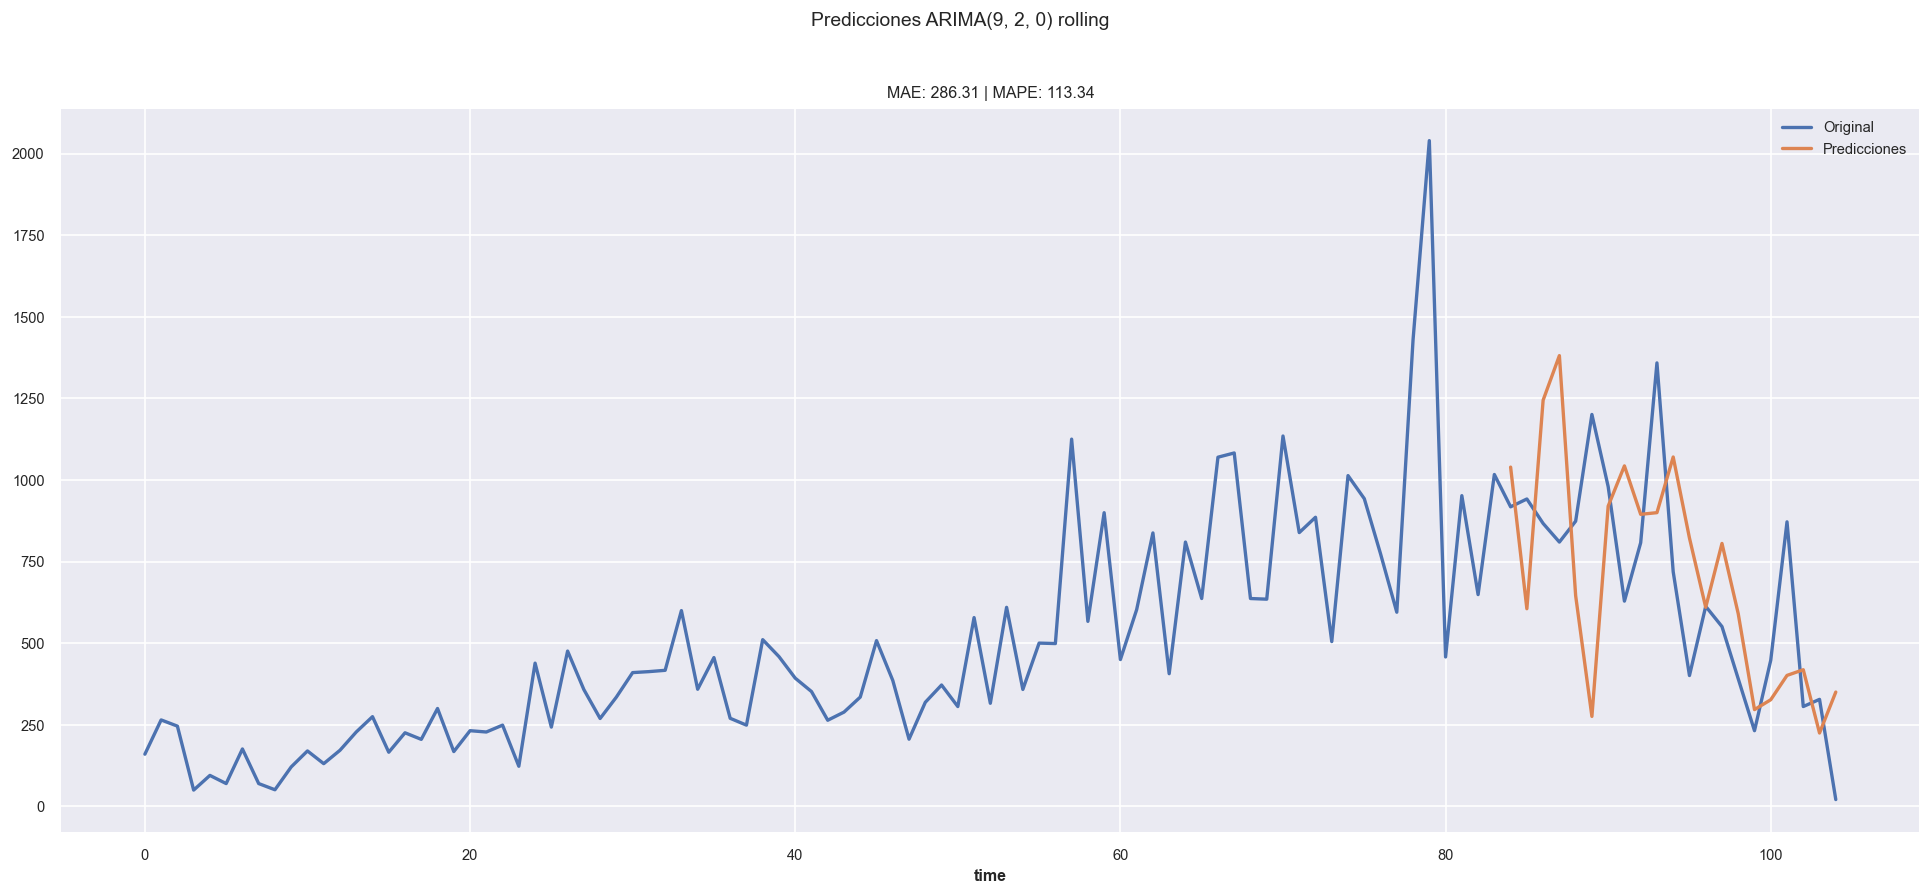

time: 344 ms (started: 2022-03-12 18:13:30 -03:00)


In [54]:
# Conseguimos las metricas de error
prediction_mae = mae(test['kilos_sum'], pred_ts)
prediction_mape = mape(test['kilos_sum'], pred_ts)
# Graficamos
plt.figure(figsize=(20, 8))
weekly_series['total']['series']['kilos_sum'].plot(label='Original')
pred_ts.plot(label='Predicciones')
plt.suptitle('Predicciones ARIMA(9, 2, 0) rolling')
plt.title('MAE: ' + str(round(prediction_mae, 2)) + ' | MAPE: ' + str(round(prediction_mape, 2)));

Vemos que el modelo mejora bastante usando Rolling Predictions, ya que el MAPE disminuye casi a la mitad y el MAE se disminuye en aproximadamente 80 kilos.

Intentaremos ahora un ARIMA(2, 2, 0)

In [55]:
# Hacemos un rolling prediction para el ARIMA(2, 2, 2)
pred = []
for i in range(len(test)):
    base_arima = ARIMA(p=2, d=2, q=0)
    train_aux = weekly_series['total']['series']['kilos_sum'][0: 84 + i]
    base_arima.fit(train_aux, future_covariates=weekly_series['total']['series']['weekOfYear'])
    preds = base_arima.predict(1, future_covariates=weekly_series['total']['series']['weekOfYear'])
    prediction = preds.values()[0]
    pred.append(prediction[0])

preds = pd.DataFrame(pred, columns=['kilos_sum'])
preds.index = test.pd_dataframe().index
pred_ts = TimeSeries.from_dataframe(preds)

time: 1.5 s (started: 2022-03-12 18:13:30 -03:00)


In [57]:
test['kilos_sum'].pd_dataframe().sum() - pred_ts.pd_dataframe().sum()

component
kilos_sum   -1137.068959
dtype: float64

time: 0 ns (started: 2022-03-12 18:13:32 -03:00)


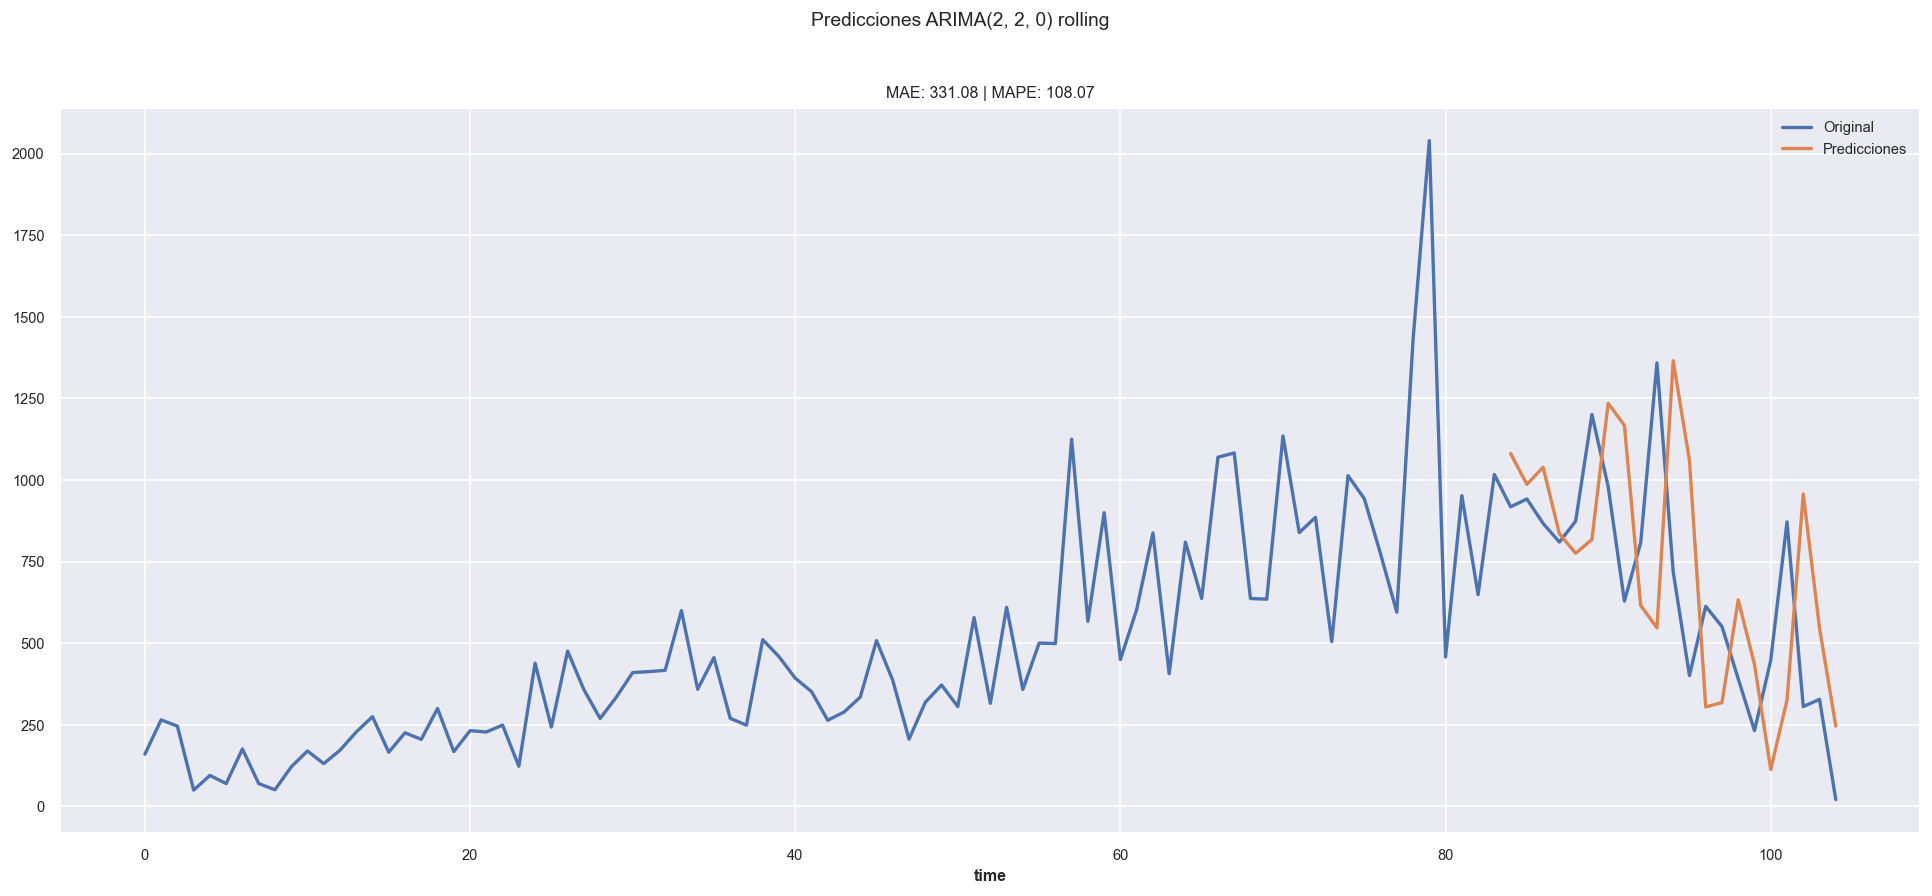

time: 328 ms (started: 2022-03-12 18:13:32 -03:00)


In [56]:
# Conseguimos las metricas de error
prediction_mae = mae(test['kilos_sum'], pred_ts)
prediction_mape = mape(test['kilos_sum'], pred_ts)
# Graficamos
plt.figure(figsize=(20, 8))
weekly_series['total']['series']['kilos_sum'].plot(label='Original')
pred_ts.plot(label='Predicciones')
plt.suptitle('Predicciones ARIMA(2, 2, 0) rolling')
plt.title('MAE: ' + str(round(prediction_mae, 2)) + ' | MAPE: ' + str(round(prediction_mape, 2)));

Notamos que la curva de predicción es muy parecida a la original pero con un desfase (lag) de aprox 2 puntos. Esto tiene sentido pues sólo ocupa dos valores previos para la predicción.

Este modelo presenta un mejor MAPE que el anterior ARIMA, pero tiene peor MAE con casi 50kg mas.

### Regresión Lineal

Haremos entonces un modelo de regresión lineal usando sólo los últimos 4 valores ().

In [101]:
from darts.models.forecasting.regression_model import RegressionModel

# Creamos una instancia de RegressionModel
pred = []
for i in range(0, len(test)):
    train_aux = weekly_series['total']['series']['kilos_sum'][0: 84 + i]
    regression = RegressionModel(lags=4)
    regression.fit(train_aux)
    # Predecimos
    predictions = regression.predict(1)
    # Guardamos la prediccion
    pred.append(predictions.values()[0][0])

preds = pd.DataFrame(pred, columns=['kilos_sum'])
preds.index = test['kilos_sum'].pd_dataframe().index
pred_ts = TimeSeries.from_dataframe(preds)
# Conseguimos las metricas de error
prediction_mae = mae(test['kilos_sum'], pred_ts)
prediction_mape = mape(test['kilos_sum'], pred_ts)

time: 375 ms (started: 2022-03-12 19:45:29 -03:00)


In [102]:
test['kilos_sum'].pd_dataframe().sum() - pred_ts.pd_dataframe().sum()

component
kilos_sum   -1348.763005
dtype: float64

time: 0 ns (started: 2022-03-12 19:45:33 -03:00)


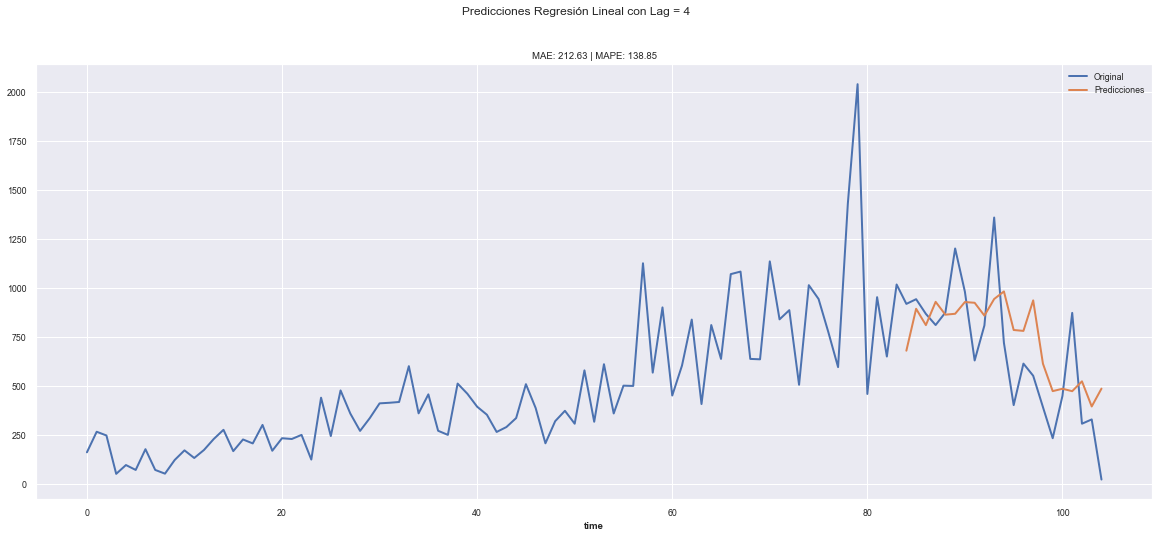

time: 234 ms (started: 2022-03-12 19:45:35 -03:00)


In [103]:
# Graficamos
plt.figure(figsize=(20, 8))
weekly_series['total']['series']['kilos_sum'].plot(label='Original')
pred_ts.plot(label='Predicciones')
plt.suptitle('Predicciones Regresión Lineal con Lag = 4')
plt.title('MAE: ' + str(round(prediction_mae, 2)) + ' | MAPE: ' + str(round(prediction_mape, 2)));

Notamos que el modelo da un MAE mejor a los anteriores, pero un MAPE peor. Notamos también que la curva de predicción es bastante mas suave, no logrando captar subidas y bajadas fuertes presentes en la serie original.

### Fast Fourier Transform

Haremos un modelo usando FFT con rolling predictions. 

In [61]:
from darts.models.forecasting.fft import FFT

# Creamos una instancia de FFT
pred = []
for i in range(0, len(test)):
    train_aux = weekly_series['total']['series']['kilos_sum'][0: 84 + i]
    fft_model = FFT(trend='exp', nr_freqs_to_keep=26)
    fft_model.fit(train_aux)
    # Predecimos
    predictions = fft_model.predict(1)
    # Guardamos la prediccion
    pred.append(predictions.values()[0][0])

preds = pd.DataFrame(pred, columns=['kilos_sum'])
preds.index = test['kilos_sum'].pd_dataframe().index
pred_ts = TimeSeries.from_dataframe(preds)
# Conseguimos las metricas de error
prediction_mae = mae(test['kilos_sum'], pred_ts)
prediction_mape = mape(test['kilos_sum'], pred_ts)


time: 157 ms (started: 2022-03-12 18:13:33 -03:00)


In [63]:
test['kilos_sum'].pd_dataframe().sum() - pred_ts.pd_dataframe().sum()

component
kilos_sum   -9249.654982
dtype: float64

time: 0 ns (started: 2022-03-12 18:13:34 -03:00)


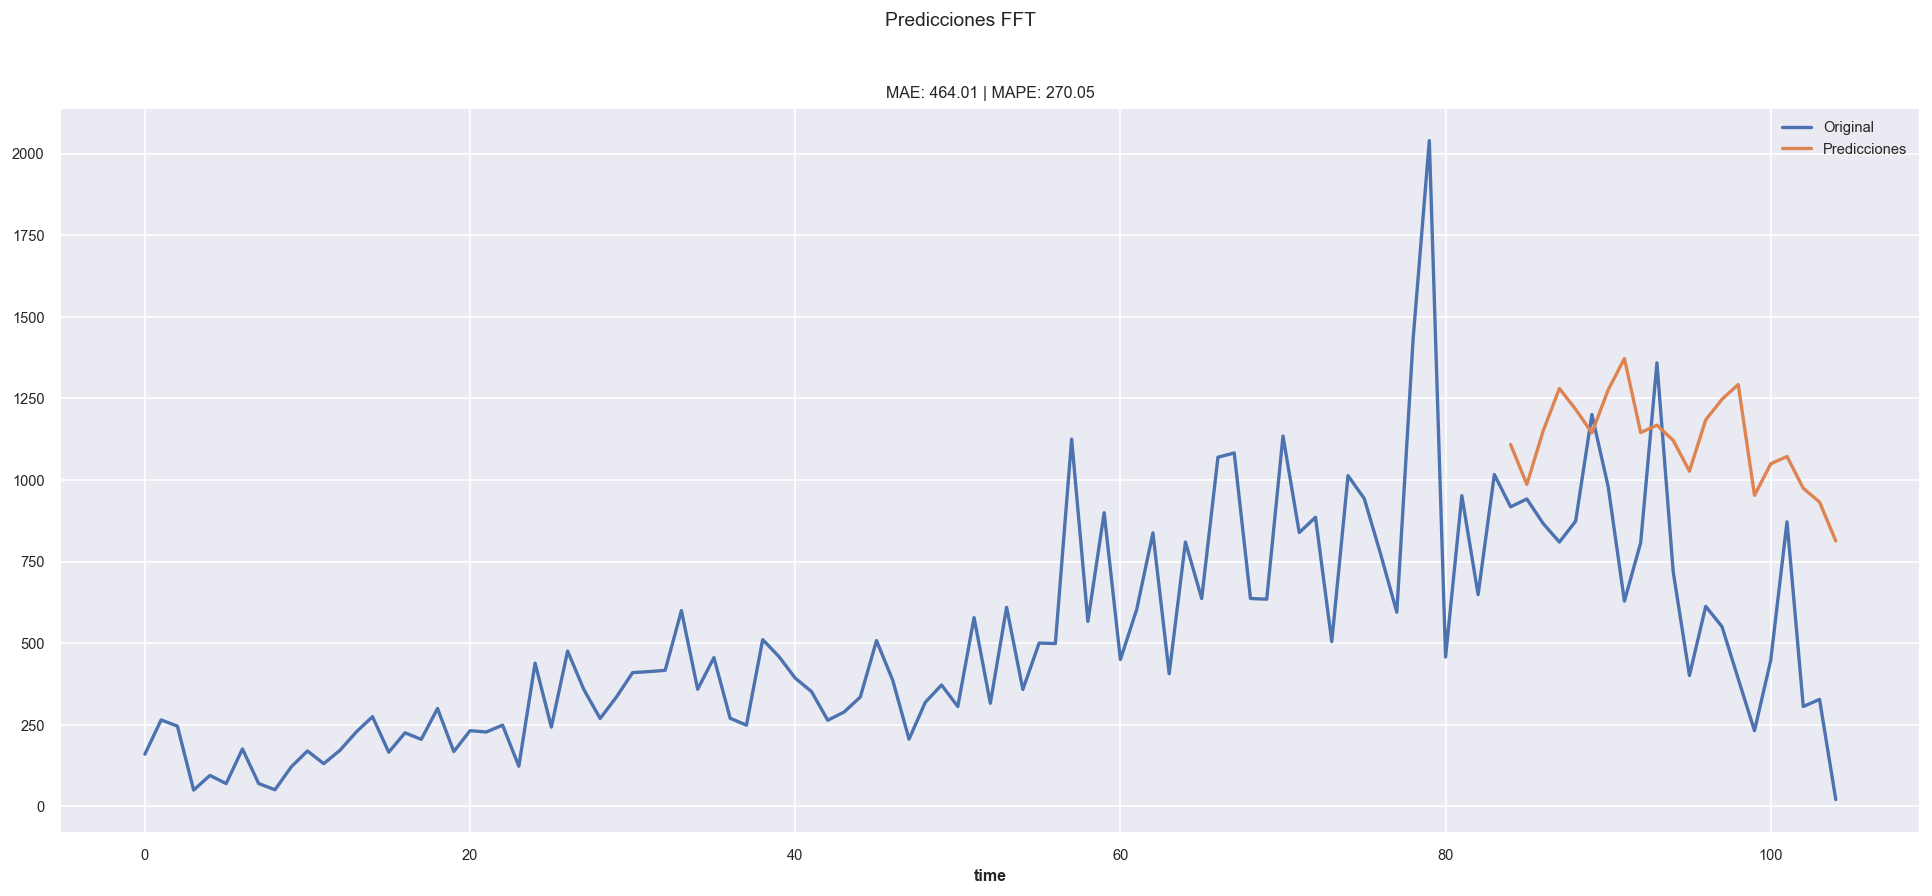

time: 297 ms (started: 2022-03-12 18:13:34 -03:00)


In [62]:
# Graficamos
plt.figure(figsize=(20, 8))
weekly_series['total']['series']['kilos_sum'].plot(label='Original')
pred_ts.plot(label='Predicciones')
plt.suptitle('Predicciones FFT')
plt.title('MAE: ' + str(round(prediction_mae, 2)) + ' | MAPE: ' + str(round(prediction_mape, 2)));

Notamos que este modelo es bastante mediocre para la predicción, ya que tiene los MAE y MAPE mas altos de todos los modelos anteriormente entrenados. El modelo continuamente sobreestima las ventas.

Fuentes:
    
1. https://towardsdatascience.com/violin-plots-explained-fb1d115e023d
2. https://machinelearningmastery.com/white-noise-time-series-python/#:~:text=A%20time%20series%20may%20be,other%20values%20in%20the%20series.
3. https://medium.com/data-science-in-your-pocket/preprocessing-for-time-series-forecasting-3a331dbfb9c2
4. https://towardsdatascience.com/violin-plots-explained-fb1d115e023d
5.http://recursostic.educacion.es/descartes/web/materiales_didacticos/unidimensional_lbarrios/asimetria_est.htm
6. 